# Exploratory Data Analysis Workshop
## The Bridge Between Raw Data and Meaningful Insight

**Dataset:** Respiratory Patient Data (OMOP CDM Synthetic Extract)

**INSTRUCTOR VERSION - WITH SOLUTIONS**

---

### Learning Objectives

By the end of this workshop, you will be able to:
1. Distinguish between seven types of analytical questions and understand their EDA requirements
2. Apply the four dimensions of exploration (distributional, relational, structural, comparative)
3. Identify data quality issues, patterns, and limitations before modeling
4. Interpret findings and distinguish signal from artifact
5. Determine appropriate next steps based on EDA outcomes

---
## Setup and Imports

Run the cell below to import the required libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')

sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 6)

%matplotlib inline

# Initialize random number generator for reproducibility, Panda's utilizes NumPy module not "random"
np.random.seed(42)

print("Libraries loaded successfully!")

Libraries loaded successfully!


---
## Part 1: Data Loading and Initial Inspection

### About the Dataset

This dataset contains synthetic patient records extracted from an OMOP Common Data Model (from OHDSI). The records represent patients with respiratory observations, including:
- Patient demographics (age, gender, race, ethnicity)
- Visit information (dates, type, conditions)
- Vital signs (temperature, oxygen saturation, heart rate, etc.)
- Vaccination history
- Patient outcomes

## Intial Analysis
With any dataset, you'll want to perform an initial "exploratory" data analysis to help you understand the structure, patterns, and relationships.

A few goals:
1. **Data Summarization** - gain an quick overview of the dataset
   - **Shape and size of data:** Number of rows, columns, and unique values.
   - **Descriptive statistics:** Mean, median, standard deviation, percentiles.
2. **Data Cleaning** - ensure data quality
   - **Handling missing values:** Identify and impute (mean/median/mode) or remove missing entries.
   - **Removing duplicates:** Eliminate redundant rows or records.
   - **Correcting data types:** Convert data to appropriate formats (e.g., dates, numbers, categories).
   - **Dealing with outliers:** Detect and decide whether to remove or transform extreme values.
3. **Feature Engineering - add additional features/variables to support analysis

In [2]:
# Read in Files and Establish Starting Dataframes
filename = 'data.csv'

In [3]:
# Load data
df = pd.read_csv(filename)

In [4]:
# Perform basic exploratory data analysis
# df.head(n)  # top n rows, n defaults to 5
# df.tail(n)  # last n rows
# df.sample(5) # sample x rows
df

,person_id,birth_datetime,race_source_value,ethnicity_source_value,gender_source_value,visit_occurrence_id,visit_start_date,visit_end_date,visit_type,condition,observation_source,age_at_visit_years,measurement_Date,body_height_cm,bmi,body_temperature_c,body_weight_kg,systolic,diastolic,heart_rate_bpm,oxygen_saturation_percent,respiratory_rate_per_minute,flu_last_administered,tdap_last_administered,mmr_last_administered,polio_last_administered,deceased
0,1,1958-12-02,white,nonhispanic,F,1,2020-03-11,2020-04-01,Inpatient Visit,Dyspnea:Pneumonia:Respiratory distress:Wheezing,Suspected COVID-19,61.27,2020-03-11,NaN,NaN,40.2,71.3,132.0,81.0,178.9,84.8,37.0,2019-09-11,2010-12-02,1962-12-02,1962-12-02,Y
1,2,1945-10-02,white,nonhispanic,F,28,2020-05-07,2020-05-07,Outpatient Visit,Viral sinusitis,NaN,74.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-04,2017-10-02,1949-10-02,1949-10-02,N
2,3,1968-04-20,white,nonhispanic,M,188,2020-03-15,2020-03-15,Outpatient Visit,Sore throat symptom:Dyspnea:Wheezing,Suspected COVID-19,51.90,2020-03-14,NaN,NaN,42.2,91.9,108.0,76.0,57.1,78.4,32.1,2019-11-19,2010-04-20,1972-04-20,1972-04-20,N
3,5,1988-08-09,white,nonhispanic,F,198,1992-08-15,1992-08-29,Outpatient Visit,Perennial allergic rhinitis,NaN,4.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1991-10-24,NaN,1992-08-09,1992-08-09,N
4,5,1988-08-09,white,nonhispanic,F,206,2020-03-10,2020-03-10,Outpatient Visit,Cough,Suspected COVID-19,31.58,2020-03-10,NaN,NaN,41.6,74.4,130.0,84.0,132.8,88.4,14.4,2019-10-23,2010-08-09,1992-08-09,1992-08-09,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156025,124148,2017-08-11,white,nonhispanic,M,3139386,2020-03-08,2020-03-08,Outpatient Visit,Cough,Suspected COVID-19,2.57,2020-03-08,NaN,NaN,39.4,12.2,108.0,83.0,170.0,84.8,32.6,2019-12-27,NaN,2018-08-11,2018-02-11,N
156026,124149,1948-12-16,black,nonhispanic,F,3139391,2019-10-23,2019-10-23,Outpatient Visit,Viral sinusitis,NaN,70.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-08,2010-12-16,1952-12-16,1952-12-16,N
156027,124149,1948-12-16,black,nonhispanic,F,3139397,2020-02-14,2020-03-06,Inpatient Visit,Acute respiratory failure:Pneumonia:Respirator...,Suspected COVID-19,71.16,2020-02-14,NaN,NaN,39.0,77.1,119.0,73.0,149.8,87.5,13.6,2019-12-12,2010-12-16,1952-12-16,1952-12-16,N
156028,124149,1948-12-16,black,nonhispanic,F,3139393,2020-03-17,2020-03-17,Outpatient Visit,Viral sinusitis,NaN,71.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-04,2010-12-16,1952-12-16,1952-12-16,N


In [5]:
print("Dataframe shape:",df.shape)
print(df.info())

Dataframe shape: (156030, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156030 entries, 0 to 156029
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   person_id                    156030 non-null  int64  
 1   birth_datetime               156030 non-null  object 
 2   race_source_value            156030 non-null  object 
 3   ethnicity_source_value       156030 non-null  object 
 4   gender_source_value          156030 non-null  object 
 5   visit_occurrence_id          156030 non-null  int64  
 6   visit_start_date             156030 non-null  object 
 7   visit_end_date               156030 non-null  object 
 8   visit_type                   156030 non-null  object 
 9   condition                    156030 non-null  object 
 10  observation_source           78197 non-null   object 
 11  age_at_visit_years           156030 non-null  float64
 12  measurement_Date            

In [7]:
# Convert date fields
for c in ["visit_start_date", "visit_end_date", "birth_datetime", "measurement_Date","flu_last_administered","tdap_last_administered","mmr_last_administered","polio_last_administered"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

In [8]:
# Examine missing fields
n_rows = len(df)

missing_table = (   # create a new dataframe
    df.isna()
      .agg(['sum', 'mean'])
      .T
      .rename(columns={'sum': 'missing_count', 'mean': 'missing_percent'})
)

missing_table['missing_percent'] = (missing_table['missing_percent'] * 100).round(2)
missing_table['non_missing_count'] = n_rows - missing_table['missing_count']
missing_table['dtype'] = df.dtypes.astype(str)

missing_table = (
    missing_table
      .reset_index(names='column')
      .sort_values(by=['missing_percent', 'column'], ascending=[False, True])
      .set_index('column')
)

missing_table

,missing_count,missing_percent,non_missing_count,dtype
column,,,,
bmi,153062.0,98.10,2968.0,float64
body_height_cm,152974.0,98.04,3056.0,float64
oxygen_saturation_percent,79221.0,50.77,76809.0,float64
observation_source,77833.0,49.88,78197.0,object
body_weight_kg,76295.0,48.90,79735.0,float64
heart_rate_bpm,76295.0,48.90,79735.0,float64
respiratory_rate_per_minute,76295.0,48.90,79735.0,float64
diastolic,76285.0,48.89,79745.0,float64
systolic,76285.0,48.89,79745.0,float64


**Question:** What patterns do you notice in the missing data? Which columns have the most missing values, and why might that be?

In [9]:
# Create a column for visit length - ignoring visit type
los = (df["visit_end_date"] - df["visit_start_date"]).dt.days
df["length_of_stay_days"] = los.clip(lower=0)


# Modify labels for deceased column
df["deceased_flag"] = df["deceased"].map({"Y": "Deceased", "N": "Alive"}).fillna("Unknown").astype("category")

# columns for year and month
df["visit_year"] = df["visit_start_date"].dt.year
df["visit_month"] = df["visit_start_date"].dt.to_period("M").astype(str)

df['gender_source_value'] = df['gender_source_value'].astype('category')
df['race_source_value'] = df['race_source_value'].astype('category')
df['ethnicity_source_value'] = df['ethnicity_source_value'].astype('category')

In [10]:
# Descriptive Statistics for Numeric Columns
df.describe()

,person_id,birth_datetime,visit_occurrence_id,visit_start_date,visit_end_date,age_at_visit_years,measurement_Date,body_height_cm,bmi,body_temperature_c,body_weight_kg,systolic,diastolic,heart_rate_bpm,oxygen_saturation_percent,respiratory_rate_per_minute,flu_last_administered,tdap_last_administered,mmr_last_administered,polio_last_administered,length_of_stay_days,visit_year
count,156030.000000,156030,1.560300e+05,156030,156030,156030.000000,88854,3056.000000,2968.000000,85945.00000,79735.000000,79745.000000,79745.000000,79735.000000,76809.000000,79735.000000,156030,124884,154223,155802,156030.000000,156030.000000
mean,62077.565180,1971-12-17 22:48:31.840030784,1.566862e+06,2009-10-28 18:34:32.924437760,2009-12-29 12:17:16.046914048,37.864144,2019-08-24 19:06:15.582415872,163.141132,27.243194,39.70430,73.216472,121.312672,80.420540,123.435253,82.008590,25.559516,2009-04-26 01:44:21.134397184,2007-07-04 19:40:22.484866048,1975-06-06 06:02:43.726551808,1975-08-21 00:05:41.602803584,61.737999,2009.484920
min,1.000000,1909-06-24 00:00:00,1.000000e+00,1909-09-17 00:00:00,1909-09-17 00:00:00,0.010000,1919-05-11 00:00:00,50.600000,12.700000,36.10000,1.800000,97.000000,67.000000,50.000000,66.100000,12.000000,1908-10-06 00:00:00,1921-06-24 00:00:00,1910-07-21 00:00:00,1909-09-11 00:00:00,0.000000,1909.000000
25%,30962.000000,1953-03-09 00:00:00,7.822792e+05,2007-05-16 06:00:00,2007-10-26 00:00:00,16.160000,2020-02-28 00:00:00,159.700000,27.200000,38.50000,66.800000,113.000000,76.000000,85.100000,78.500000,18.200000,2006-10-14 00:00:00,2009-09-19 18:00:00,1956-12-04 00:00:00,1957-01-03 00:00:00,0.000000,2007.000000
50%,62111.500000,1971-06-14 00:00:00,1.566715e+06,2020-02-22 00:00:00,2020-02-24 00:00:00,36.070000,2020-03-05 00:00:00,167.700000,28.000000,39.70000,78.000000,120.000000,80.000000,122.000000,82.000000,25.500000,2019-09-13 00:00:00,2013-06-11 00:00:00,1975-01-21 00:00:00,1975-04-08 00:00:00,0.000000,2020.000000
75%,93253.500000,1994-04-29 00:00:00,2.358876e+06,2020-03-07 00:00:00,2020-03-09 00:00:00,57.170000,2020-03-10 00:00:00,176.100000,29.800000,40.90000,87.400000,128.000000,84.000000,161.500000,85.500000,32.700000,2019-11-07 00:00:00,2016-11-04 00:00:00,1997-09-01 12:00:00,1998-01-02 00:00:00,0.000000,2020.000000
max,124150.000000,2020-04-21 00:00:00,3.139398e+06,2020-05-26 00:00:00,2020-05-27 00:00:00,110.730000,2020-05-26 00:00:00,198.700000,53.300000,42.20000,181.200000,201.000000,121.000000,200.000000,89.000000,40.000000,2019-12-31 00:00:00,2020-05-25 00:00:00,2020-05-19 00:00:00,2020-05-25 00:00:00,38325.000000,2020.000000
std,35919.884529,NaN,9.067587e+05,NaN,NaN,25.103145,NaN,23.250398,4.428474,1.42849,22.775382,13.423653,6.791986,43.523960,4.050973,8.243366,NaN,NaN,NaN,NaN,995.266731,19.479078


In [11]:
# for categorical columns
df.describe(include=['object','category'])

,race_source_value,ethnicity_source_value,gender_source_value,visit_type,condition,observation_source,deceased,deceased_flag,visit_month
count,156030,156030,156030,156030,156030,78197,156030,156030,156030
unique,5,2,2,3,4185,21,2,2,1295
top,white,nonhispanic,M,Outpatient Visit,Cough,Suspected COVID-19,N,Alive,2020-03
freq,131136,138838,78691,134954,33292,73304,139602,139602,62667


In [12]:
# Create an alternate view of the conditions, placingin into a separate tidy dataframe
import re

# robust split on ":" allowing extra spaces; keep NaN if empty
def split_conditions(s):
    if pd.isna(s) or str(s).strip() == "":
        return []
    # split on ":" with optional surrounding spaces
    parts = re.split(r"\s*:\s*", str(s))
    # normalize: strip, drop empties, lower (or title-case if you prefer)
    parts = [p.strip() for p in parts if p and p.strip()]
    return parts

# apply once to create a list-typed column
df["condition_list"] = df["condition"].map(split_conditions)

cond_long = (
    df[["visit_occurrence_id", "person_id", "visit_start_date"]]
      .assign(condition_item=df["condition_list"])
      .explode("condition_item", ignore_index=True)
)

# drop rows where no condition exists after cleaning
cond_long = cond_long.dropna(subset=["condition_item"])

# (optional) dedupe within visit in case the same condition appears twice
cond_long = cond_long.drop_duplicates(subset=["visit_occurrence_id", "condition_item"])
cond_long

,visit_occurrence_id,person_id,visit_start_date,condition_item
0,1,1,2020-03-11,Dyspnea
1,1,1,2020-03-11,Pneumonia
2,1,1,2020-03-11,Respiratory distress
3,1,1,2020-03-11,Wheezing
4,28,2,2020-05-07,Viral sinusitis
...,...,...,...,...
249048,3139398,124150,2020-03-07,Wheezing
249049,3139398,124150,2020-03-07,Cough
249050,3139398,124150,2020-03-07,Respiratory distress
249051,3139398,124150,2020-03-07,Pneumonia


In [13]:
# For outpatient visits, assume this is a data issue and the length should be 0
is_outpatient = df['visit_type'].astype(str).str.contains('outpatient', case=False, na=False)

# align dates, then recompute LOS as zero
df.loc[is_outpatient, 'visit_end_date'] = df.loc[is_outpatient, 'visit_start_date']
df.loc[is_outpatient, 'length_of_stay_days'] = 0

# remove any records where length_of_stay_days > 100
df = df[df["length_of_stay_days"] <= 100].copy()

---
## Part 2: Distributional Exploration

**Goal:** Examine individual variables to understand their scale, shape, and validity.

### The Seven Question Types

Before we explore, remember that the type of question determines the EDA approach:

| Type | Core Question | Example |
|------|--------------|--------|
| Descriptive | What happened? | What is the distribution of conditions? |
| Exploratory | What patterns exist? | Is there a relationship between temperature and O2 sat? |
| Inferential | Does this generalize? | Is the O2 sat difference statistically significant? |
| Predictive | What will happen? | Can we predict inpatient admission? |
| Prescriptive | What should we do? | What thresholds should trigger escalation? |
| Causal | What if we intervene? | Would earlier vaccination reduce severity? |
| Mechanistic | What process produces this? | How does symptom progression unfold? |

### Exercise 2.1: Demographic Distributions

Create frequency counts for the following categorical variables:
1. Gender (`gender_source_value`)
2. Race (`race_source_value`)
3. Ethnicity (`ethnicity_source_value`)

**Note:** For demographics, we should look at unique patients, not all visits (since one patient can have multiple visits).

In [14]:
# First, create a dataframe of unique patients
patients = df.drop_duplicates(subset='person_id')

print(f"Total unique patients: {len(patients)}")

Total unique patients: 98966


In [15]:
# Gender distribution
gender_counts = patients['gender_source_value'].value_counts()
print("\nGender Distribution:")
print(gender_counts)
print(f"\nPercentages:")
print(patients['gender_source_value'].value_counts(normalize=True) * 100)


Gender Distribution:
gender_source_value
M    49520
F    49446
Name: count, dtype: int64

Percentages:
gender_source_value
M    50.037387
F    49.962613
Name: proportion, dtype: float64


In [16]:
# Race distribution
race_counts = patients['race_source_value'].value_counts()
print("\nRace Distribution:")
print(race_counts)
print(f"\nPercentages:")
print(patients['race_source_value'].value_counts(normalize=True) * 100)


Race Distribution:
race_source_value
white     83204
black      8333
asian      6841
native      480
other       108
Name: count, dtype: int64

Percentages:
race_source_value
white     84.073318
black      8.420063
asian      6.912475
native     0.485015
other      0.109128
Name: proportion, dtype: float64


In [17]:
# Ethnicity distribution
ethnicity_counts = patients['ethnicity_source_value'].value_counts()
print("\nEthnicity Distribution:")
print(ethnicity_counts)
print(f"\nPercentages:")
print(patients['ethnicity_source_value'].value_counts(normalize=True) * 100)


Ethnicity Distribution:
ethnicity_source_value
nonhispanic    88011
hispanic       10955
Name: count, dtype: int64

Percentages:
ethnicity_source_value
nonhispanic    88.930542
hispanic       11.069458
Name: proportion, dtype: float64


### Exercise 2.2: Age Distribution

1. Calculate descriptive statistics for `age_at_visit_years`
2. Create a histogram of the age distribution
3. Create age groups (Pediatric: 0-18, Young Adult: 18-40, Middle Age: 40-65, Elderly: 65+)

In [18]:
# 1. Descriptive statistics for age
print("Age Descriptive Statistics:")
print(df['age_at_visit_years'].describe())

Age Descriptive Statistics:
count    155972.000000
mean         37.856991
std          25.102684
min           0.010000
25%          16.160000
50%          36.050000
75%          57.160000
max         110.730000
Name: age_at_visit_years, dtype: float64


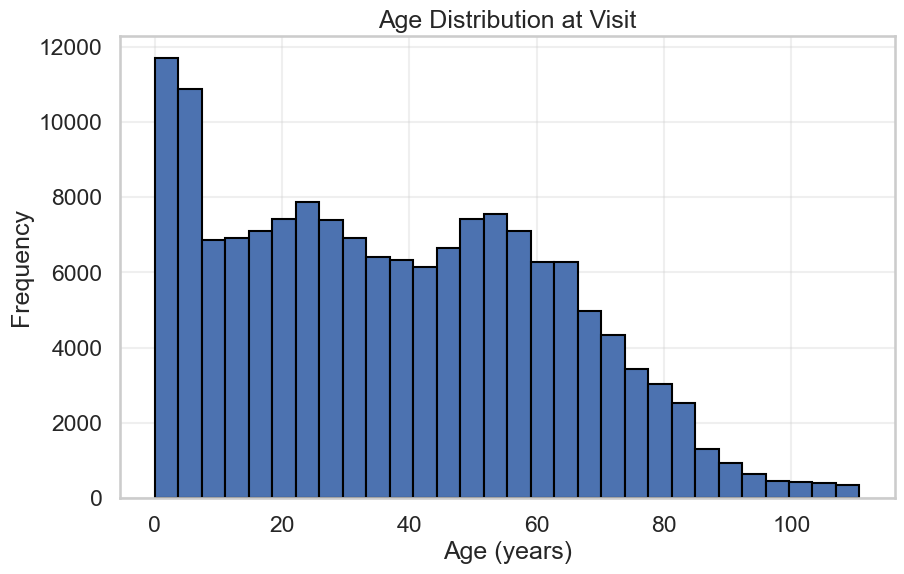

In [19]:
# 2. Histogram of age distribution
plt.figure(figsize=(10, 6))
plt.hist(df['age_at_visit_years'].dropna(), bins=30, edgecolor='black')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.title('Age Distribution at Visit')
plt.grid(True, alpha=0.3)
plt.show()

In [20]:
# 3. Create age groups and show their distribution
df['age_group'] = pd.cut(df['age_at_visit_years'],
                         bins=[0, 18, 40, 65, 100],
                         labels=['Pediatric', 'Young Adult', 'Middle Age', 'Elderly'])

age_group_counts = df['age_group'].value_counts().sort_index()
print("\nAge Group Distribution:")
print(age_group_counts)
print("\nPercentages:")
print(df['age_group'].value_counts(normalize=True).sort_index() * 100)


Age Group Distribution:
age_group
Pediatric      42577
Young Adult    41987
Middle Age     46333
Elderly        23938
Name: count, dtype: int64

Percentages:
age_group
Pediatric      27.498305
Young Adult    27.117254
Middle Age     29.924113
Elderly        15.460329
Name: proportion, dtype: float64


### Exercise 2.3: Condition Analysis

The `condition` column contains multiple conditions separated by colons (`:`).

1. Parse the conditions into individual items
2. Count the frequency of each condition
3. Create a bar chart of the top 10 conditions

In [21]:
# 1. Parse conditions (split by colon) - already done earlier, but repeating here
df['condition_list'] = df['condition'].str.split(':')

# 2. Explode and count
all_conditions = df['condition_list'].explode()
all_conditions = all_conditions.str.strip()  # Remove whitespace
condition_counts = all_conditions.value_counts()

print("Top 10 Conditions:")
print(condition_counts.head(10))

Top 10 Conditions:
condition_list
Cough                        63418
Chronic sinusitis            26760
Pneumonia                    20436
Respiratory distress         19111
Dyspnea                      18511
Wheezing                     18511
Viral sinusitis              16223
Sore throat symptom          13163
Acute respiratory failure     9124
Acute viral pharyngitis       8344
Name: count, dtype: int64


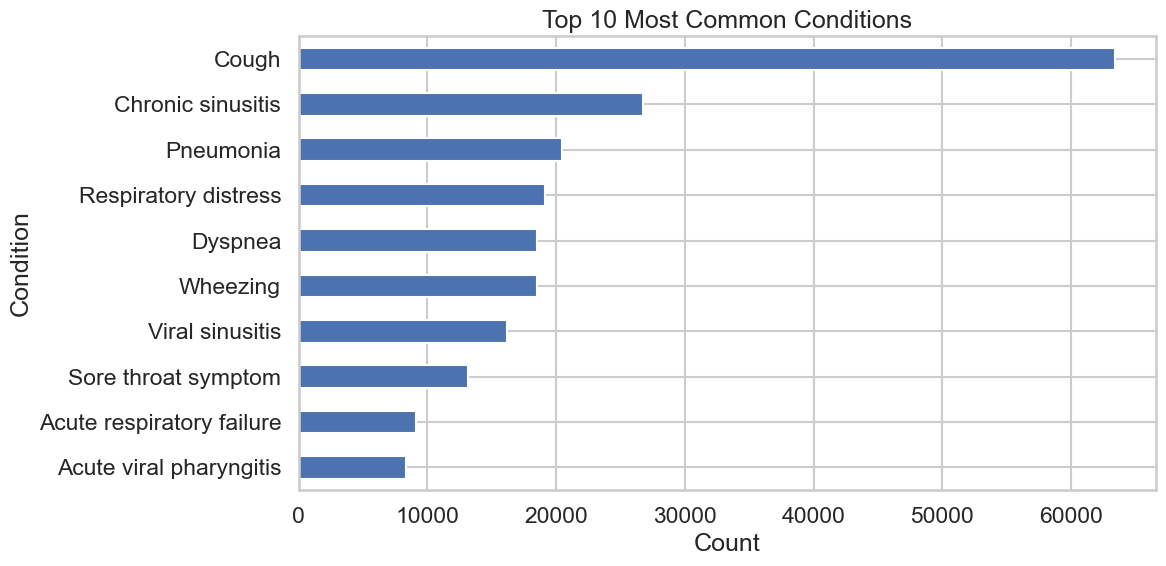

In [22]:
# 3. Bar chart of top 10 conditions
plt.figure(figsize=(12, 6))
condition_counts.head(10).plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Condition')
plt.title('Top 10 Most Common Conditions')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Exercise 2.4: Vital Signs Distribution (COVID-Suspected Patients)

Many vital signs are only recorded for COVID-suspected visits.

1. Filter the data to only COVID-suspected patients (`observation_source == 'Suspected COVID-19'`)
2. Calculate descriptive statistics for the vital signs columns
3. Create histograms for oxygen saturation, respiratory rate, heart rate, and body temperature

In [23]:
# 1. Filter to COVID-suspected patients
covid_df = df[df['observation_source'] == 'Suspected COVID-19']

print(f"COVID-suspected visits: {len(covid_df)}")
print(f"Total visits: {len(df)}")
print(f"Percentage: {len(covid_df)/len(df)*100:.1f}%")

COVID-suspected visits: 73294
Total visits: 155972
Percentage: 47.0%


In [24]:
# 2. Descriptive statistics for vital signs
vital_cols = ['oxygen_saturation_percent', 'respiratory_rate_per_minute',
              'heart_rate_bpm', 'body_temperature_c', 'systolic', 'diastolic']

print("Vital Signs Descriptive Statistics (COVID-Suspected Patients):")
print(covid_df[vital_cols].describe())

Vital Signs Descriptive Statistics (COVID-Suspected Patients):
       oxygen_saturation_percent  respiratory_rate_per_minute  heart_rate_bpm  \
count               73280.000000                 73291.000000    73291.000000   
mean                   82.006122                    25.998889      125.129858   
std                     4.050182                     8.073657       43.418865   
min                    75.000000                    12.000000       50.000000   
25%                    78.500000                    19.000000       87.400000   
50%                    82.000000                    26.000000      125.100000   
75%                    85.500000                    33.000000      163.000000   
max                    89.000000                    40.000000      200.000000   

       body_temperature_c      systolic     diastolic  
count        73283.000000  73291.000000  73291.000000  
mean            39.948594    121.270688     80.398698  
std              1.300469     13.341257

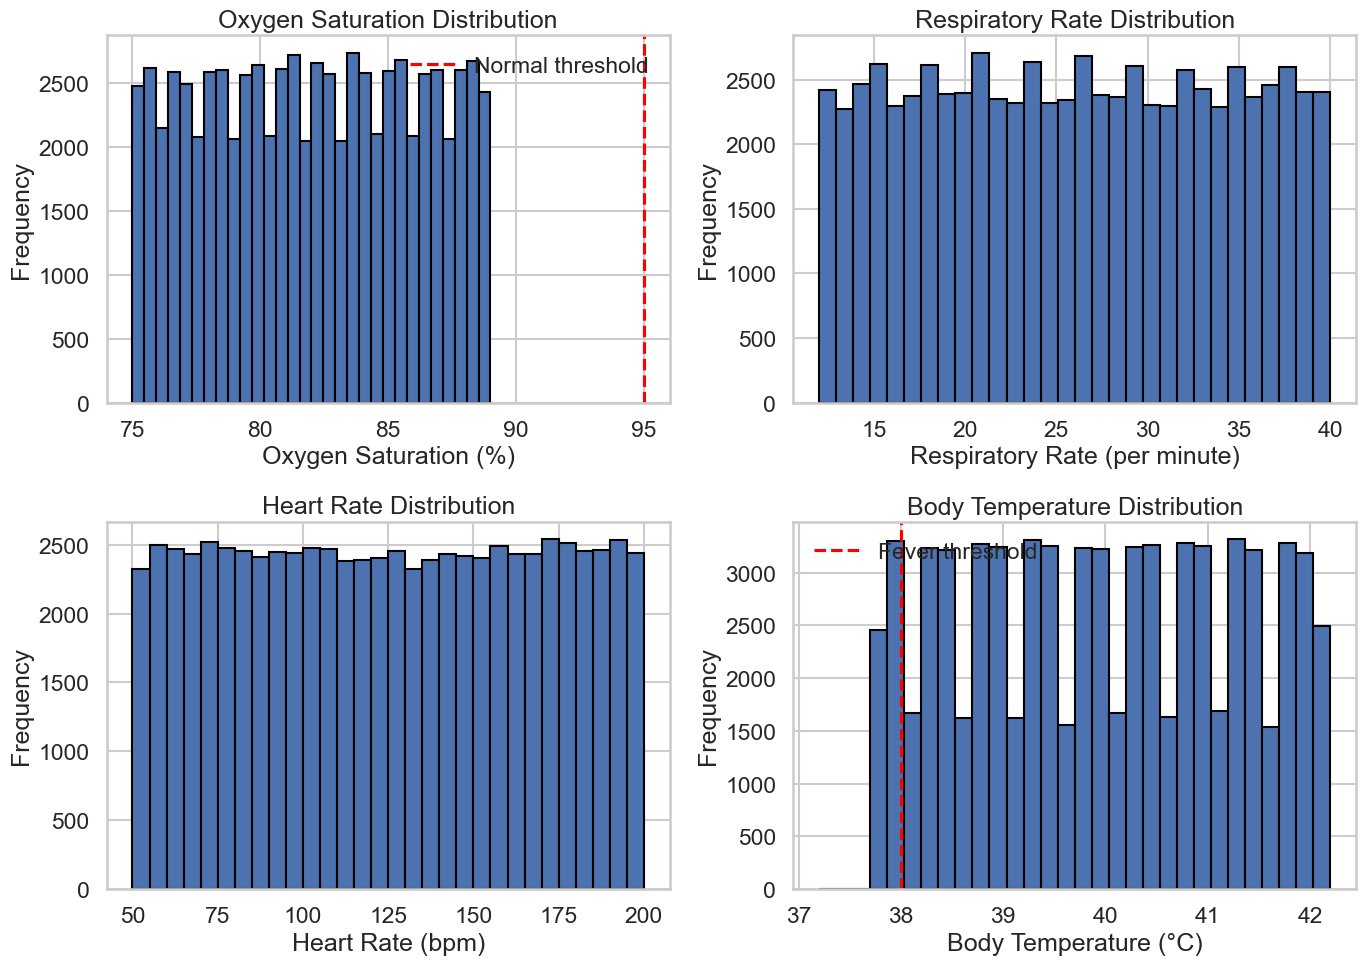

In [25]:
# 3. Create histograms (2x2 subplot)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Oxygen saturation
axes[0, 0].hist(covid_df['oxygen_saturation_percent'].dropna(), bins=30, edgecolor='black')
axes[0, 0].set_xlabel('Oxygen Saturation (%)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Oxygen Saturation Distribution')
axes[0, 0].axvline(95, color='red', linestyle='--', label='Normal threshold')
axes[0, 0].legend()

# Respiratory rate
axes[0, 1].hist(covid_df['respiratory_rate_per_minute'].dropna(), bins=30, edgecolor='black')
axes[0, 1].set_xlabel('Respiratory Rate (per minute)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Respiratory Rate Distribution')

# Heart rate
axes[1, 0].hist(covid_df['heart_rate_bpm'].dropna(), bins=30, edgecolor='black')
axes[1, 0].set_xlabel('Heart Rate (bpm)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Heart Rate Distribution')

# Body temperature
axes[1, 1].hist(covid_df['body_temperature_c'].dropna(), bins=30, edgecolor='black')
axes[1, 1].set_xlabel('Body Temperature (°C)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Body Temperature Distribution')
axes[1, 1].axvline(38, color='red', linestyle='--', label='Fever threshold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

**Question:** Are there any concerning values in the vital signs? What might explain extreme values?

*Instructor notes:*

Students should identify:
- Oxygen saturation values below 90% (hypoxemia) and especially below 80% (severe hypoxemia)
- Extremely high or low temperatures that may indicate data entry errors or critical conditions
- Very high heart rates (>180 bpm) or respiratory rates (>40/min) that may be artifacts or represent critical illness
- Some extreme values may be biologically implausible and could indicate measurement errors or data quality issues
- The distribution of values should be discussed in terms of clinical significance vs. data quality concerns

### Exercise 2.5: Visit Type Distribution

1. Count the number of Inpatient vs Outpatient visits
2. Calculate the percentage of each type
3. Create a pie chart or bar chart showing the distribution

Visit Type Distribution:
visit_type
Outpatient Visit        134954
Inpatient Visit          20998
Emergency Room Visit        20
Name: count, dtype: int64

Percentages:
visit_type
Outpatient Visit        86.524504
Inpatient Visit         13.462673
Emergency Room Visit     0.012823
Name: proportion, dtype: float64


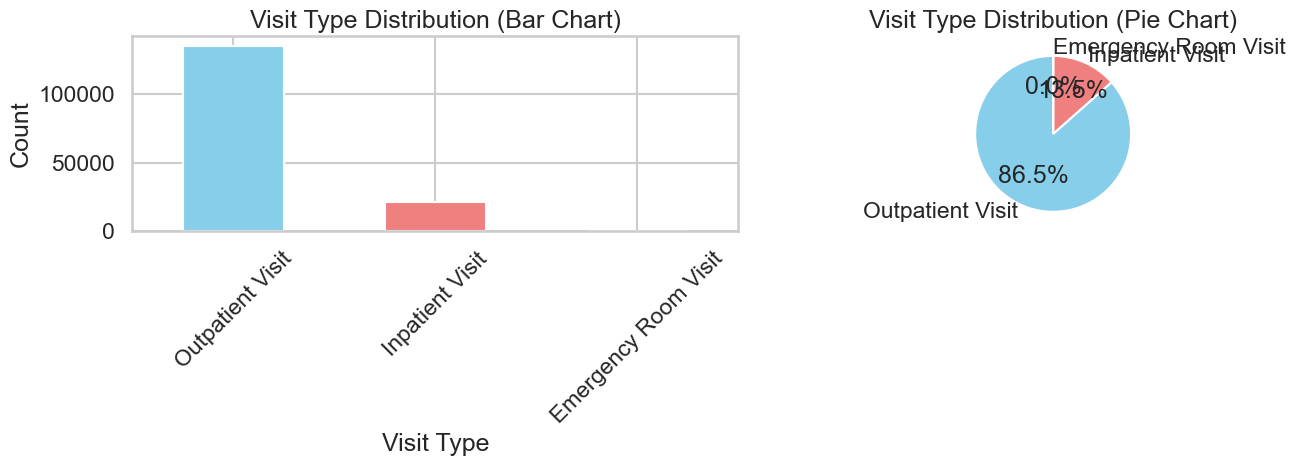

In [26]:
# 1-2. Count and percentage
visit_type_counts = df['visit_type'].value_counts()
visit_type_pct = df['visit_type'].value_counts(normalize=True) * 100

print("Visit Type Distribution:")
print(visit_type_counts)
print("\nPercentages:")
print(visit_type_pct)

# 3. Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
visit_type_counts.plot(kind='bar', ax=axes[0], color=['skyblue', 'lightcoral'])
axes[0].set_xlabel('Visit Type')
axes[0].set_ylabel('Count')
axes[0].set_title('Visit Type Distribution (Bar Chart)')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].pie(visit_type_counts, labels=visit_type_counts.index, autopct='%1.1f%%',
            colors=['skyblue', 'lightcoral'], startangle=90)
axes[1].set_title('Visit Type Distribution (Pie Chart)')

plt.tight_layout()
plt.show()

### Exercise 2.6: Outlier Detection in Vital Signs

Identify potential outliers in vital sign measurements. Consider clinical validity:
- Temperature: Normal 36-37.5°C, fever >38°C, extreme >42°C
- Oxygen saturation: Normal >95%, concerning <90%, critical <80%
- Heart rate: Normal 60-100 bpm, tachycardia >100, extreme >180
- Respiratory rate: Normal 12-20/min, elevated >24, extreme >40

**Dimension focus:** Distributional exploration

In [27]:
# Identify outliers based on clinical thresholds
outlier_summary = pd.DataFrame({
    'Vital Sign': ['Temperature', 'Oxygen Saturation', 'Heart Rate', 'Respiratory Rate'],
    'Extreme (count)': [
        (covid_df['body_temperature_c'] > 42).sum(),
        (covid_df['oxygen_saturation_percent'] < 80).sum(),
        (covid_df['heart_rate_bpm'] > 180).sum(),
        (covid_df['respiratory_rate_per_minute'] > 40).sum()
    ],
    'Concerning (count)': [
        ((covid_df['body_temperature_c'] > 38) & (covid_df['body_temperature_c'] <= 42)).sum(),
        ((covid_df['oxygen_saturation_percent'] < 90) & (covid_df['oxygen_saturation_percent'] >= 80)).sum(),
        ((covid_df['heart_rate_bpm'] > 100) & (covid_df['heart_rate_bpm'] <= 180)).sum(),
        ((covid_df['respiratory_rate_per_minute'] > 24) & (covid_df['respiratory_rate_per_minute'] <= 40)).sum()
    ]
})

print("Outlier Analysis for Vital Signs:")
print(outlier_summary)

# Show some extreme cases
print("\nExtreme Temperature Cases:")
extreme_temp = covid_df[covid_df['body_temperature_c'] > 42][['person_id', 'body_temperature_c', 'deceased']]
print(extreme_temp.head())

print("\nCritical Oxygen Saturation Cases:")
critical_o2 = covid_df[covid_df['oxygen_saturation_percent'] < 80][['person_id', 'oxygen_saturation_percent', 'deceased']]
print(critical_o2.head())

Outlier Analysis for Vital Signs:
          Vital Sign  Extreme (count)  Concerning (count)
0        Temperature             2497               65026
1  Oxygen Saturation            25801               47479
2         Heart Rate             9841               38946
3   Respiratory Rate                0               41681

Extreme Temperature Cases:
     person_id  body_temperature_c deceased
2            3                42.2        N
119         87                42.1        N
225        162                42.1        Y
335        249                42.2        Y
373        283                42.1        N

Critical Oxygen Saturation Cases:
    person_id  oxygen_saturation_percent deceased
2           3                       78.4        N
8           9                       79.8        N
14         14                       77.0        N
18         18                       78.3        N
37         32                       76.1        Y


---
## Part 3: Relational Exploration

**Goal:** Investigate how multiple variables interact rather than treating them in isolation.

### Exercise 3.1: Correlation Matrix

Create a correlation matrix heatmap for the numeric vital sign variables using the COVID-suspected patient data.

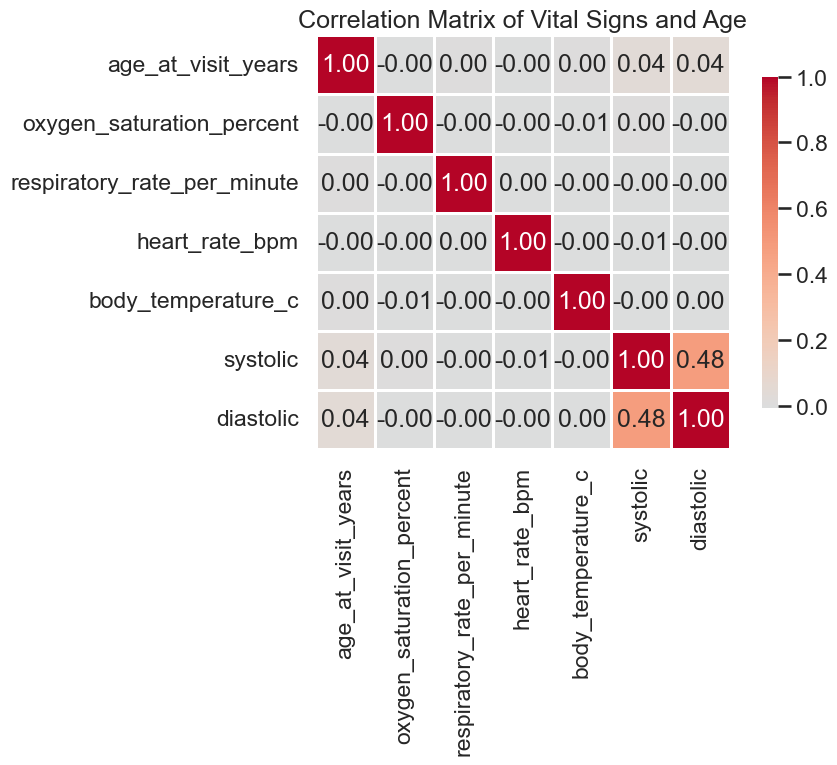


Strongest correlations (absolute value > 0.3):
systolic  diastolic    0.47851
dtype: float64


In [28]:
# Select numeric columns for correlation
numeric_cols = ['age_at_visit_years', 'oxygen_saturation_percent',
                'respiratory_rate_per_minute', 'heart_rate_bpm',
                'body_temperature_c', 'systolic', 'diastolic']

# Calculate correlation matrix
corr_matrix = covid_df[numeric_cols].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Vital Signs and Age')
plt.tight_layout()
plt.show()

print("\nStrongest correlations (absolute value > 0.3):")
# Get upper triangle of correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_pairs = corr_matrix.where(mask).stack().sort_values(ascending=False)
strong_corr = corr_pairs[abs(corr_pairs) > 0.3]
print(strong_corr)

**Question:** What correlations do you observe? Are any surprising or concerning?

*Instructor notes:*

Students should identify:
- Systolic and diastolic blood pressure are highly correlated (expected)
- Negative correlation between oxygen saturation and respiratory rate (hypoxic patients breathe faster)
- Weak or no correlation between some variables may indicate independence or non-linear relationships
- Age correlations with vital signs may reveal age-related physiological patterns
- Discuss whether observed correlations are clinically meaningful or potential confounders

### Exercise 3.2: Temperature vs Oxygen Saturation

Create a scatter plot examining the relationship between body temperature and oxygen saturation. Color the points by the `deceased` status.

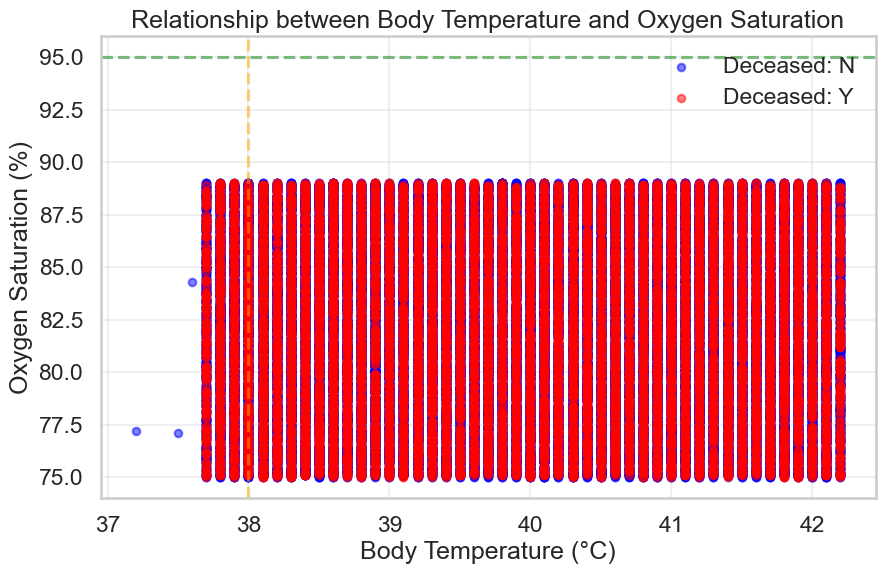

In [29]:
# Filter data with both measurements
temp_o2_data = covid_df.dropna(subset=['body_temperature_c', 'oxygen_saturation_percent', 'deceased'])

# Create scatter plot
plt.figure(figsize=(10, 6))
colors = {'Y': 'red', 'N': 'blue'}
for deceased_status, group in temp_o2_data.groupby('deceased'):
    plt.scatter(group['body_temperature_c'], group['oxygen_saturation_percent'],
                c=colors[deceased_status], label=f"Deceased: {deceased_status}",
                alpha=0.5, s=30)

plt.xlabel('Body Temperature (°C)')
plt.ylabel('Oxygen Saturation (%)')
plt.title('Relationship between Body Temperature and Oxygen Saturation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=95, color='green', linestyle='--', alpha=0.5, label='Normal O2 threshold')
plt.axvline(x=38, color='orange', linestyle='--', alpha=0.5, label='Fever threshold')
plt.show()

### Exercise 3.3: Condition Count and Vital Signs

1. Create a variable `condition_count` that counts the number of conditions per visit (count the colons + 1)
2. Compare the mean vital signs between patients with 1-2 conditions vs 3+ conditions

In [30]:
# 1. Create condition count
df['condition_count'] = df['condition'].str.count(':') + 1

# Check the distribution
print("Condition Count Distribution:")
print(df['condition_count'].value_counts().sort_index())

Condition Count Distribution:
condition_count
1     116783
2      13778
3      11905
4       5929
5       3696
6       2564
7        597
8        344
9          8
10       214
12       116
14        24
15         2
16         5
18         1
21         1
28         1
36         2
42         2
Name: count, dtype: int64


In [31]:
# 2. Compare vital signs by condition severity (1-2 vs 3+)
# First add condition_count to covid_df
covid_df = covid_df.copy()
covid_df['condition_count'] = covid_df['condition'].str.count(':') + 1
covid_df['high_condition_count'] = covid_df['condition_count'] >= 3

# Compare vital signs
vital_comparison = covid_df.groupby('high_condition_count')[vital_cols].mean()
print("\nMean Vital Signs by Condition Severity:")
print(vital_comparison)

# Calculate differences
print("\nDifference (3+ conditions minus 1-2 conditions):")
difference = vital_comparison.loc[True] - vital_comparison.loc[False]
print(difference)


Mean Vital Signs by Condition Severity:
                      oxygen_saturation_percent  respiratory_rate_per_minute  \
high_condition_count                                                           
False                                 82.027384                    25.990959   
True                                  81.962630                    26.015106   

                      heart_rate_bpm  body_temperature_c    systolic  \
high_condition_count                                                   
False                     124.971083           39.949861  121.038317   
True                      125.454537           39.946002  121.745866   

                      diastolic  
high_condition_count             
False                 80.277260  
True                  80.647029  

Difference (3+ conditions minus 1-2 conditions):
oxygen_saturation_percent     -0.064754
respiratory_rate_per_minute    0.024147
heart_rate_bpm                 0.483453
body_temperature_c            -0.003858
sys

### Exercise 3.4: Visit Type and Vital Signs

Compare vital signs between Inpatient and Outpatient visits. Create box plots showing the distribution of oxygen saturation by visit type.

<Figure size 1000x600 with 0 Axes>

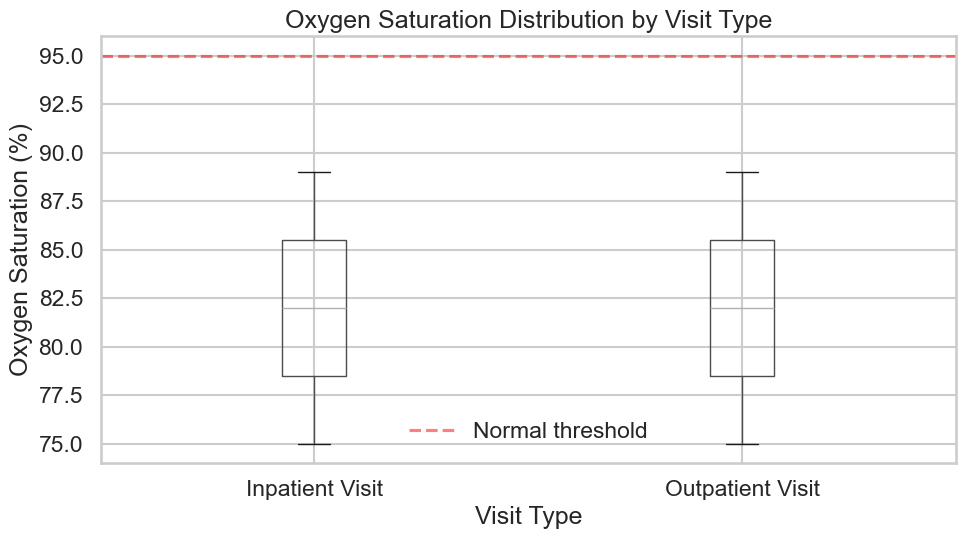


Oxygen Saturation Statistics by Visit Type:
                    count       mean       std   min   25%   50%   75%   max
visit_type                                                                  
Inpatient Visit   16464.0  81.991053  4.055954  75.0  78.5  82.0  85.5  89.0
Outpatient Visit  56816.0  82.010488  4.048533  75.0  78.5  82.0  85.5  89.0


In [32]:
# Box plots for oxygen saturation by visit type
plt.figure(figsize=(10, 6))
covid_df.boxplot(column='oxygen_saturation_percent', by='visit_type', figsize=(10, 6))
plt.suptitle('')  # Remove default title
plt.title('Oxygen Saturation Distribution by Visit Type')
plt.xlabel('Visit Type')
plt.ylabel('Oxygen Saturation (%)')
plt.axhline(y=95, color='red', linestyle='--', alpha=0.5, label='Normal threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Summary statistics
print("\nOxygen Saturation Statistics by Visit Type:")
print(covid_df.groupby('visit_type')['oxygen_saturation_percent'].describe())

### Exercise 3.5: Deceased Status and Vital Signs

1. Calculate the mean and median vital signs grouped by deceased status (Y/N)
2. Create box plots comparing oxygen saturation between deceased and non-deceased patients

In [33]:
# 1. Mean/median vital signs by deceased status
deceased_vital_stats = covid_df.groupby('deceased')[vital_cols].agg(['mean', 'median'])
print("Vital Signs by Deceased Status:")
print(deceased_vital_stats)

Vital Signs by Deceased Status:
         oxygen_saturation_percent        respiratory_rate_per_minute         \
                              mean median                        mean median   
deceased                                                                       
N                        82.015710   82.0                   25.990114   26.0   
Y                        81.971948   81.9                   26.030168   26.0   

         heart_rate_bpm        body_temperature_c           systolic         \
                   mean median               mean median        mean median   
deceased                                                                      
N            125.283812  125.4          39.950985   40.0  121.200178  120.0   
Y            124.581099  123.6          39.940072   39.9  121.522015  120.0   

          diastolic         
               mean median  
deceased                    
N         80.356466   80.0  
Y         80.549231   80.0  


<Figure size 1000x600 with 0 Axes>

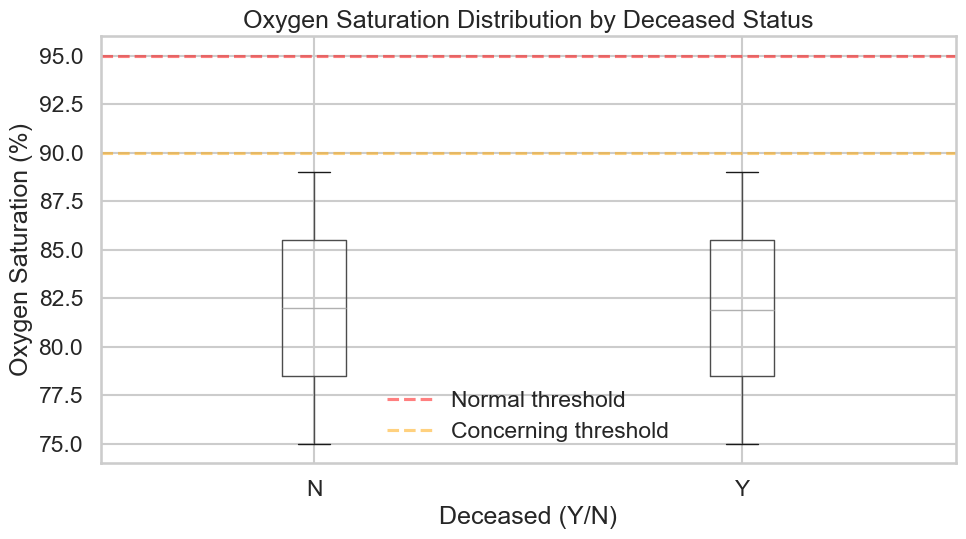

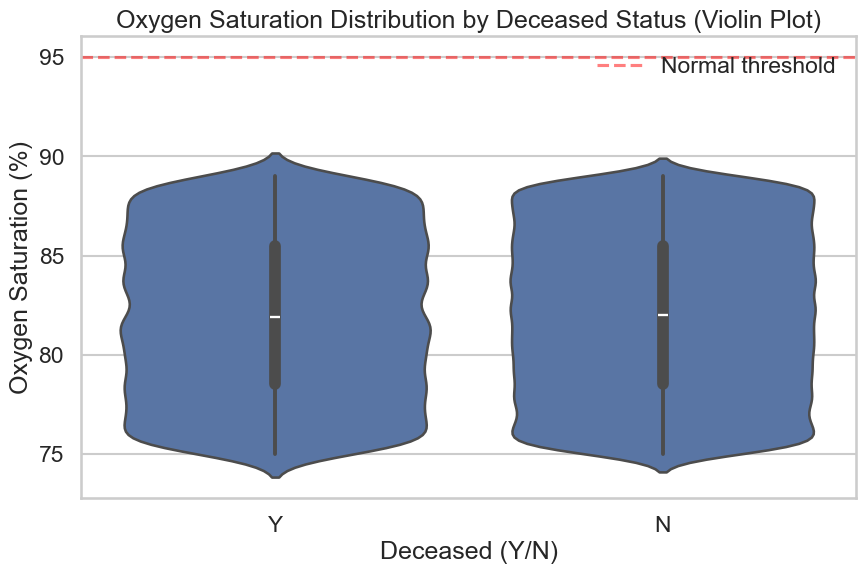

In [34]:
# 2. Box plots for oxygen saturation by deceased status
plt.figure(figsize=(10, 6))
covid_df.boxplot(column='oxygen_saturation_percent', by='deceased', figsize=(10, 6))
plt.suptitle('')  # Remove default title
plt.title('Oxygen Saturation Distribution by Deceased Status')
plt.xlabel('Deceased (Y/N)')
plt.ylabel('Oxygen Saturation (%)')
plt.axhline(y=95, color='red', linestyle='--', alpha=0.5, label='Normal threshold')
plt.axhline(y=90, color='orange', linestyle='--', alpha=0.5, label='Concerning threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Alternative: side-by-side violin plots
plt.figure(figsize=(10, 6))
sns.violinplot(data=covid_df, x='deceased', y='oxygen_saturation_percent')
plt.title('Oxygen Saturation Distribution by Deceased Status (Violin Plot)')
plt.xlabel('Deceased (Y/N)')
plt.ylabel('Oxygen Saturation (%)')
plt.axhline(y=95, color='red', linestyle='--', alpha=0.5, label='Normal threshold')
plt.legend()
plt.show()

---
## Part 4: Structural Exploration

**Goal:** Analyze temporal, hierarchical, and sequential patterns in the data.

### Exercise 4.1: Date Preparation

Convert the date columns to datetime format and extract useful components.

In [35]:
# Convert date columns to datetime (already done in data prep, but repeating for clarity)
df['visit_start_date'] = pd.to_datetime(df['visit_start_date'])
df['visit_end_date'] = pd.to_datetime(df['visit_end_date'])

# Extract year and month
df['visit_year'] = df['visit_start_date'].dt.year
df['visit_month'] = df['visit_start_date'].dt.to_period('M').astype(str)

print("Date columns prepared successfully!")
print(f"\nDate range: {df['visit_start_date'].min()} to {df['visit_start_date'].max()}")

Date columns prepared successfully!

Date range: 1909-09-17 00:00:00 to 2020-05-26 00:00:00


### Exercise 4.2: Temporal Distribution of Visits

1. Count the number of visits by year
2. For 2020, create a bar chart showing visits by month
3. What patterns do you observe?

Visits by Year:
visit_year
1909        1
1910        1
1911        7
1912       11
1913       14
        ...  
2016     1213
2017     1185
2018     1238
2019    16922
2020    86706
Name: count, Length: 112, dtype: int64


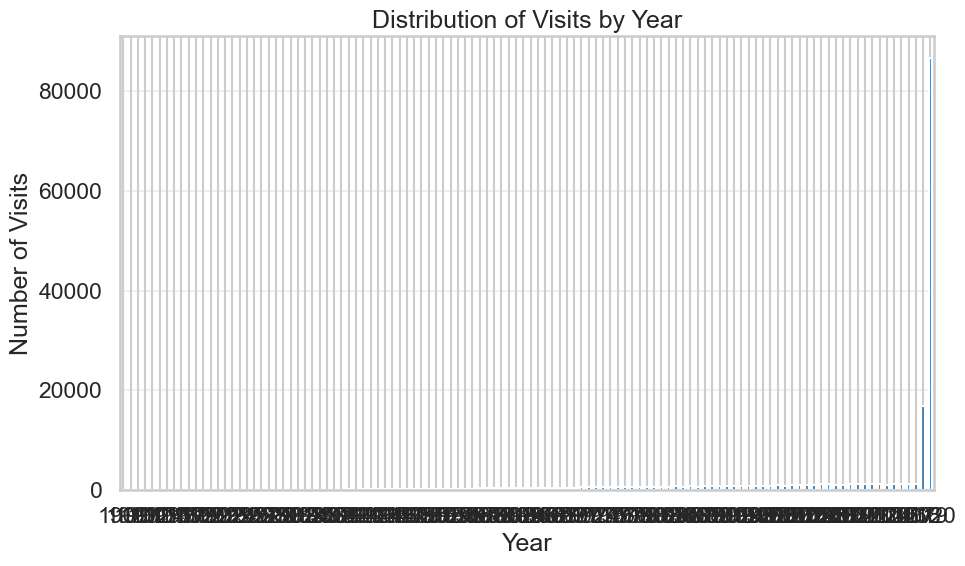

In [36]:
# 1. Visits by year
visits_by_year = df['visit_year'].value_counts().sort_index()
print("Visits by Year:")
print(visits_by_year)

# Plot
plt.figure(figsize=(10, 6))
visits_by_year.plot(kind='bar', color='steelblue')
plt.xlabel('Year')
plt.ylabel('Number of Visits')
plt.title('Distribution of Visits by Year')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


2020 Visits by Month:
visit_month
2020-01     2366
2020-02    18007
2020-03    62667
2020-04     2078
2020-05     1588
Name: count, dtype: int64


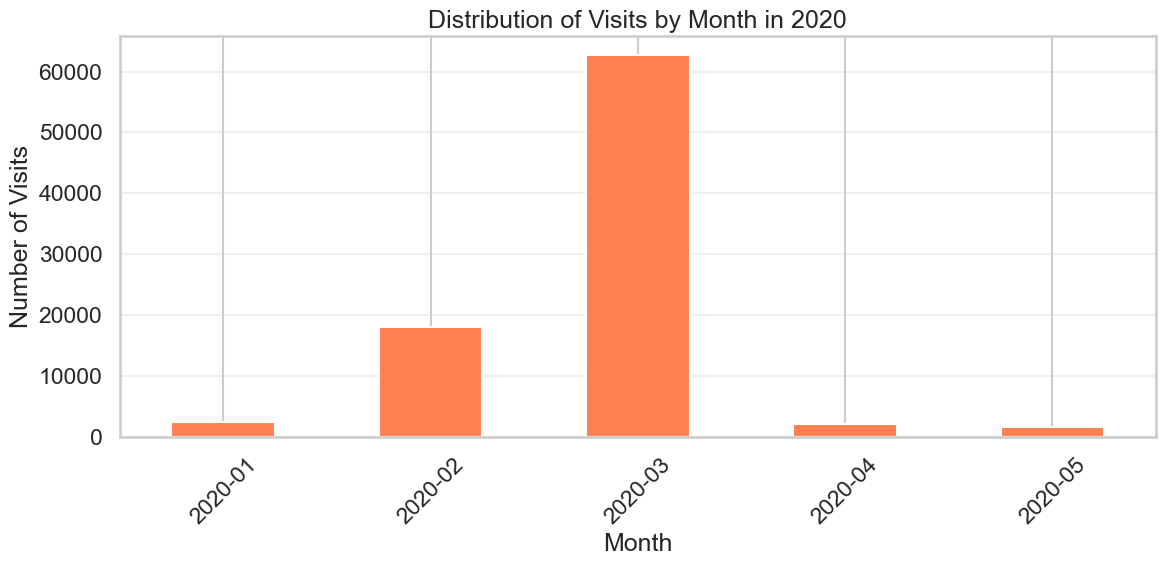


3. Pattern observations:
- Look for seasonal trends (e.g., respiratory illness peaks in winter)
- COVID-19 pandemic impact should be visible in 2020
- Sudden spikes or drops may indicate data collection changes or real events


In [37]:
# 2. Bar chart of 2020 visits by month
df_2020 = df[df['visit_year'] == 2020]
visits_2020_by_month = df_2020['visit_month'].value_counts().sort_index()

print("\n2020 Visits by Month:")
print(visits_2020_by_month)

plt.figure(figsize=(12, 6))
visits_2020_by_month.plot(kind='bar', color='coral')
plt.xlabel('Month')
plt.ylabel('Number of Visits')
plt.title('Distribution of Visits by Month in 2020')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n3. Pattern observations:")
print("- Look for seasonal trends (e.g., respiratory illness peaks in winter)")
print("- COVID-19 pandemic impact should be visible in 2020")
print("- Sudden spikes or drops may indicate data collection changes or real events")

### Exercise 4.3: Length of Stay Analysis

1. Calculate the length of stay (in days) for each visit
2. Filter to inpatient visits only
3. Calculate descriptive statistics for length of stay
4. Create a histogram of length of stay

In [38]:
# 1. Calculate length of stay (already done in prep, but showing here)
df['length_of_stay'] = (df['visit_end_date'] - df['visit_start_date']).dt.days
df['length_of_stay'] = df['length_of_stay'].clip(lower=0)  # No negative values

Length of Stay Statistics (Inpatient Visits):
count    20998.000000
mean        13.467664
std          5.604954
min          1.000000
25%         11.000000
50%         14.000000
75%         17.000000
max         43.000000
Name: length_of_stay, dtype: float64


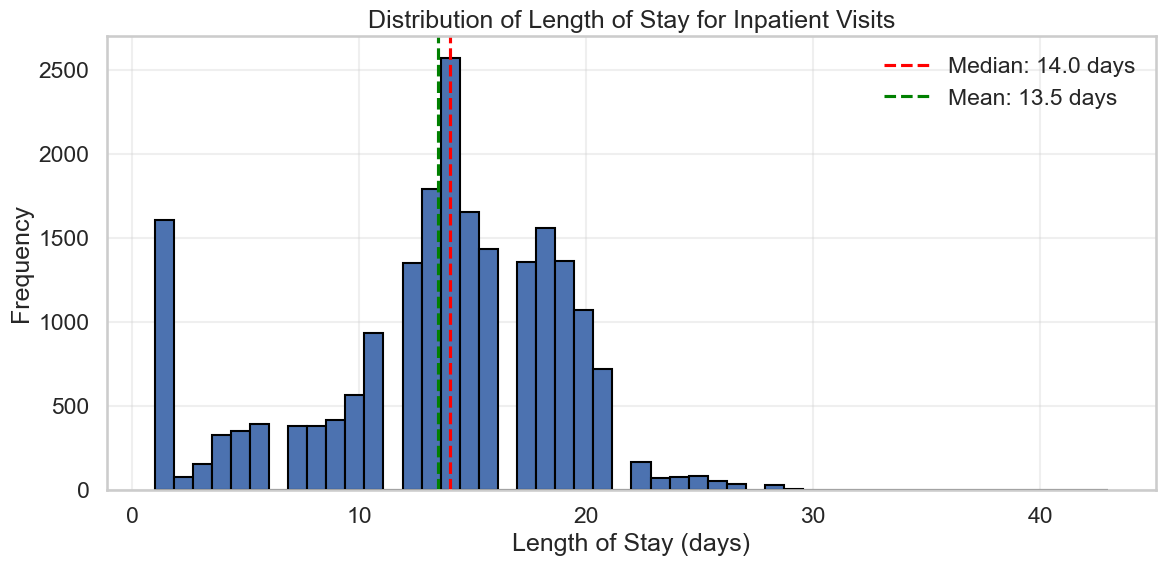


Visits with LOS > 30 days: 3
Visits with LOS > 60 days: 0


In [39]:
# 2-4. Inpatient length of stay analysis
inpatient_df = df[df['visit_type'].str.contains('Inpatient', na=False)]

print("Length of Stay Statistics (Inpatient Visits):")
print(inpatient_df['length_of_stay'].describe())

# Histogram
plt.figure(figsize=(12, 6))
plt.hist(inpatient_df['length_of_stay'].dropna(), bins=50, edgecolor='black')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Length of Stay for Inpatient Visits')
plt.axvline(inpatient_df['length_of_stay'].median(), color='red', 
            linestyle='--', label=f"Median: {inpatient_df['length_of_stay'].median():.1f} days")
plt.axvline(inpatient_df['length_of_stay'].mean(), color='green', 
            linestyle='--', label=f"Mean: {inpatient_df['length_of_stay'].mean():.1f} days")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check for outliers
print(f"\nVisits with LOS > 30 days: {(inpatient_df['length_of_stay'] > 30).sum()}")
print(f"Visits with LOS > 60 days: {(inpatient_df['length_of_stay'] > 60).sum()}")

### Exercise 4.4: Patient Visit History

1. Count the number of visits per patient
2. What percentage of patients have multiple visits?
3. Find a patient with multiple visits and examine their visit history

In [40]:
# 1. Visits per patient
visits_per_patient = df.groupby('person_id').size().reset_index(name='visit_count')

print("Distribution of Visit Counts:")
print(visits_per_patient['visit_count'].value_counts().sort_index())

Distribution of Visit Counts:
visit_count
1     57578
2     30569
3      8484
4      1544
5       310
6       112
7       108
8        62
9        60
10       54
11       29
12       24
13        6
14       11
15        9
16        4
17        1
19        1
Name: count, dtype: int64


In [41]:
# 2. Percentage with multiple visits
multiple_visits = (visits_per_patient['visit_count'] > 1).sum()
total_patients = len(visits_per_patient)
pct_multiple = (multiple_visits / total_patients) * 100

print(f"\nPatients with multiple visits: {multiple_visits} ({pct_multiple:.1f}%)")
print(f"Patients with single visit: {total_patients - multiple_visits} ({100-pct_multiple:.1f}%)")


Patients with multiple visits: 41388 (41.8%)
Patients with single visit: 57578 (58.2%)


In [42]:
# 3. Examine a patient with multiple visits
# Find patient with most visits
most_visits_patient = visits_per_patient.loc[visits_per_patient['visit_count'].idxmax(), 'person_id']

print(f"\nPatient with most visits: {most_visits_patient}")
print(f"Number of visits: {visits_per_patient[visits_per_patient['person_id'] == most_visits_patient]['visit_count'].values[0]}")

# Show their visit history
patient_history = df[df['person_id'] == most_visits_patient][[
    'visit_occurrence_id', 'visit_start_date', 'visit_end_date', 'visit_type',
    'condition', 'deceased', 'length_of_stay'
]].sort_values('visit_start_date')

print("\nVisit History:")
print(patient_history)


Patient with most visits: 26705
Number of visits: 19

Visit History:
       visit_occurrence_id visit_start_date visit_end_date        visit_type  \
33721               674554       1917-08-09     1917-08-09  Outpatient Visit   
33722               674555       1919-08-18     1919-08-18  Outpatient Visit   
33723               674556       1924-11-12     1924-11-12  Outpatient Visit   
33724               674557       1926-10-24     1926-10-24  Outpatient Visit   
33725               674558       1930-02-01     1930-02-01  Outpatient Visit   
33726               674559       1934-06-09     1934-06-09  Outpatient Visit   
33727               674560       1937-09-14     1937-09-14  Outpatient Visit   
33728               674561       1947-04-17     1947-04-17  Outpatient Visit   
33729               674562       1948-03-25     1948-03-25  Outpatient Visit   
33730               674563       1950-04-05     1950-04-05  Outpatient Visit   
33731               674564       1967-03-05     19

### Exercise 4.5: Vaccination Timeline Analysis

1. Calculate the time between the last flu vaccination and the visit date
2. What percentage of patients were vaccinated within the past year (365 days) before their visit?

In [43]:
# 1. Calculate days since flu vaccine
df['flu_last_administered'] = pd.to_datetime(df['flu_last_administered'])
df['days_since_flu_vaccine'] = (df['visit_start_date'] - df['flu_last_administered']).dt.days

print("Days Since Flu Vaccine Statistics:")
print(df['days_since_flu_vaccine'].describe())

Days Since Flu Vaccine Statistics:
count    155972.000000
mean        185.668575
std         101.807361
min           1.000000
25%         110.000000
50%         156.000000
75%         246.000000
max         486.000000
Name: days_since_flu_vaccine, dtype: float64



Total visits with vaccination data: 155972
Vaccinated within past year: 142811 (91.6%)


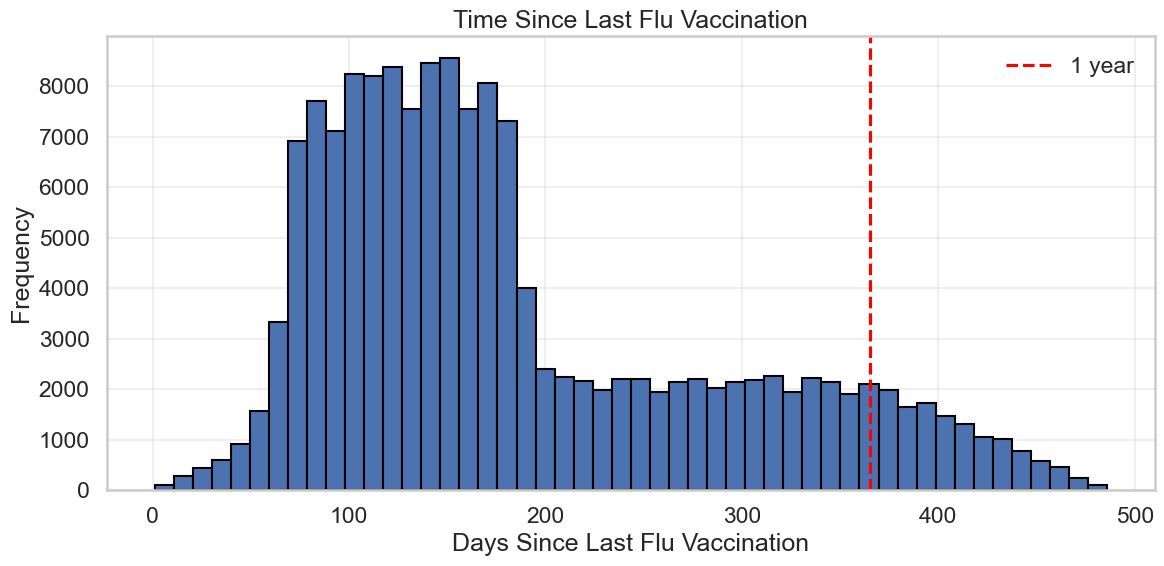

In [44]:
# 2. Percentage vaccinated within past year
has_vaccine_data = df['days_since_flu_vaccine'].notna()
vaccinated_within_year = (df['days_since_flu_vaccine'] <= 365) & (df['days_since_flu_vaccine'] >= 0)

total_with_data = has_vaccine_data.sum()
vaccinated_count = vaccinated_within_year.sum()
pct_vaccinated = (vaccinated_count / total_with_data) * 100 if total_with_data > 0 else 0

print(f"\nTotal visits with vaccination data: {total_with_data}")
print(f"Vaccinated within past year: {vaccinated_count} ({pct_vaccinated:.1f}%)")

# Histogram
plt.figure(figsize=(12, 6))
plt.hist(df[df['days_since_flu_vaccine'] >= 0]['days_since_flu_vaccine'].dropna(), 
         bins=50, edgecolor='black')
plt.xlabel('Days Since Last Flu Vaccination')
plt.ylabel('Frequency')
plt.title('Time Since Last Flu Vaccination')
plt.axvline(365, color='red', linestyle='--', label='1 year')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## Part 5: Comparative Exploration

**Goal:** Study differences across groups, time periods, or conditions.

### Exercise 5.1: Mortality Rate Comparison

1. Calculate the overall mortality rate (percentage with deceased='Y')
2. Compare mortality rates by visit type (Inpatient vs Outpatient)
3. Compare mortality rates by age group

In [45]:
# 1. Overall mortality rate
overall_mortality_rate = (df['deceased'] == 'Y').mean() * 100
print(f"Overall mortality rate: {overall_mortality_rate:.2f}%")

Overall mortality rate: 10.52%



Mortality Rate by Visit Type (%):
deceased                       N          Y
visit_type                                 
Emergency Room Visit  100.000000   0.000000
Inpatient Visit        69.763787  30.236213
Outpatient Visit       92.547831   7.452169


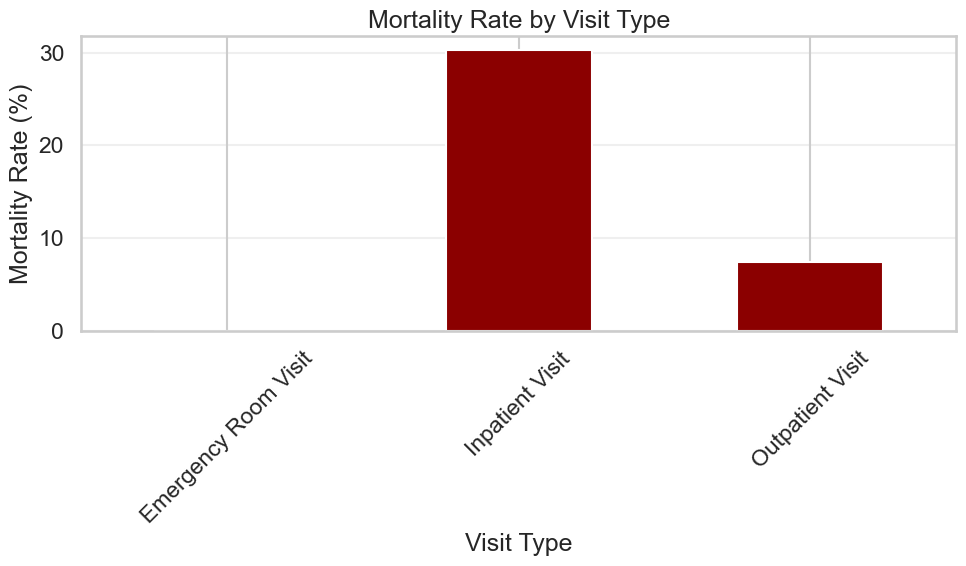

In [46]:
# 2. Mortality by visit type
mortality_by_visit = pd.crosstab(
    df['visit_type'],
    df['deceased'],
    normalize='index'
) * 100

print("\nMortality Rate by Visit Type (%):")
print(mortality_by_visit)

# Visualization
mortality_by_visit['Y'].plot(kind='bar', color='darkred', figsize=(10, 6))
plt.title('Mortality Rate by Visit Type')
plt.xlabel('Visit Type')
plt.ylabel('Mortality Rate (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


Mortality Rate by Age Group (%):
deceased             N          Y
age_group                        
Pediatric    98.130446   1.869554
Young Adult  91.818896   8.181104
Middle Age   84.341614  15.658386
Elderly      80.992564  19.007436


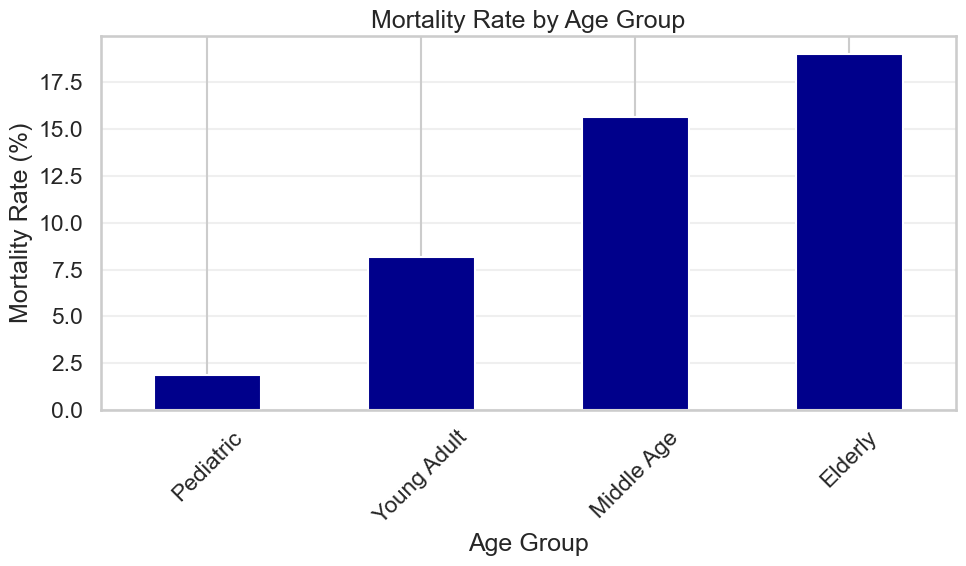

In [47]:
# 3. Mortality by age group
# First ensure age_group exists
if 'age_group' not in df.columns:
    df['age_group'] = pd.cut(df['age_at_visit_years'],
                             bins=[0, 18, 40, 65, 100],
                             labels=['Pediatric', 'Young Adult', 'Middle Age', 'Elderly'])

mortality_by_age = pd.crosstab(
    df['age_group'],
    df['deceased'],
    normalize='index'
) * 100

print("\nMortality Rate by Age Group (%):")
print(mortality_by_age)

# Visualization
mortality_by_age['Y'].plot(kind='bar', color='darkblue', figsize=(10, 6))
plt.title('Mortality Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Mortality Rate (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Exercise 5.2: Visit Type by Age Group

Create a cross-tabulation showing what percentage of each age group has Inpatient vs Outpatient visits.

Visit Type Distribution by Age Group (%):
visit_type   Emergency Room Visit  Inpatient Visit  Outpatient Visit
age_group                                                           
Pediatric                0.023487         2.388614         97.587900
Young Adult              0.014290        10.274609         89.711101
Middle Age               0.006475        18.386463         81.607062
Elderly                  0.004177        28.243796         71.752026


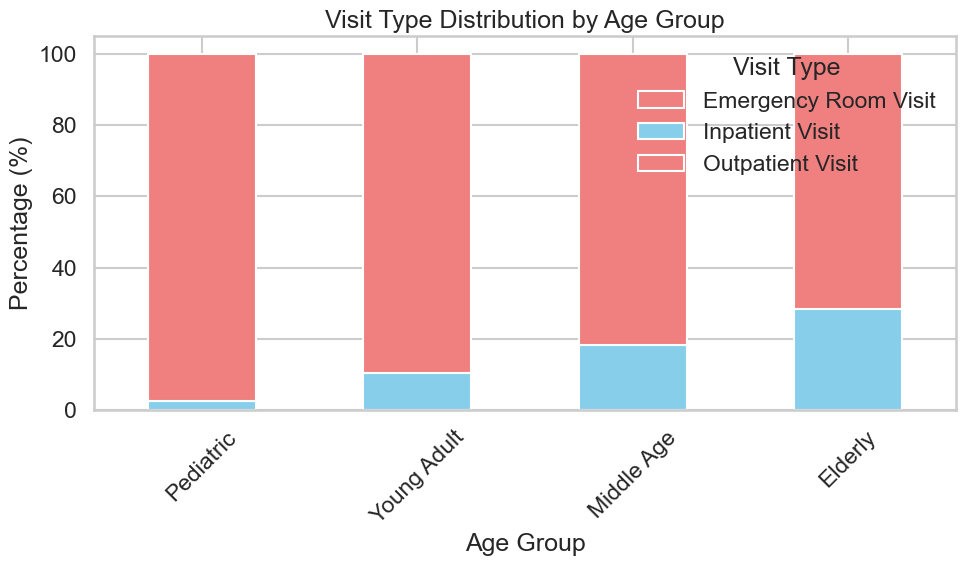

In [48]:
visit_by_age = pd.crosstab(
    df['age_group'],
    df['visit_type'],
    normalize='index'
) * 100

print("Visit Type Distribution by Age Group (%):")
print(visit_by_age)

# Stacked bar chart
visit_by_age.plot(kind='bar', stacked=True, figsize=(10, 6), 
                  color=['lightcoral', 'skyblue'])
plt.title('Visit Type Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage (%)')
plt.legend(title='Visit Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Exercise 5.3: COVID vs Non-COVID Comparison

Compare characteristics between COVID-suspected and non-COVID visits:
1. Average age
2. Visit type distribution
3. Mortality rate

COVID-Suspected vs Non-COVID Comparison:
                      avg_age  mortality_rate  inpatient_rate  n_visits
is_covid_suspected                                                     
False               34.601800         0.42212        5.483926     82678
True                41.528952        21.90766       22.462957     73294


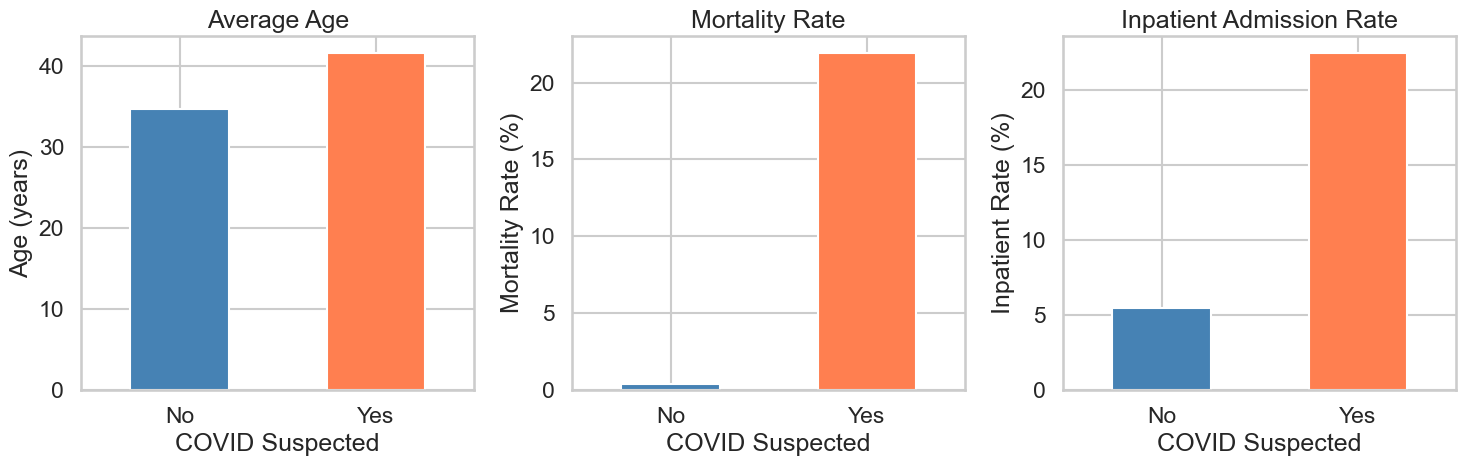

In [49]:
# Create a COVID indicator
df['is_covid_suspected'] = df['observation_source'] == 'Suspected COVID-19'

# Compare the groups
covid_summary = df.groupby('is_covid_suspected').agg(
    avg_age=('age_at_visit_years', 'mean'),
    mortality_rate=('deceased', lambda x: (x == 'Y').mean() * 100),
    inpatient_rate=('visit_type', lambda x: (x.str.contains('Inpatient')).mean() * 100),
    n_visits=('person_id', 'count')
)

print("COVID-Suspected vs Non-COVID Comparison:")
print(covid_summary)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Average age
covid_summary['avg_age'].plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Average Age')
axes[0].set_xlabel('COVID Suspected')
axes[0].set_ylabel('Age (years)')
axes[0].set_xticklabels(['No', 'Yes'], rotation=0)

# Mortality rate
covid_summary['mortality_rate'].plot(kind='bar', ax=axes[1], color=['steelblue', 'coral'])
axes[1].set_title('Mortality Rate')
axes[1].set_xlabel('COVID Suspected')
axes[1].set_ylabel('Mortality Rate (%)')
axes[1].set_xticklabels(['No', 'Yes'], rotation=0)

# Inpatient rate
covid_summary['inpatient_rate'].plot(kind='bar', ax=axes[2], color=['steelblue', 'coral'])
axes[2].set_title('Inpatient Admission Rate')
axes[2].set_xlabel('COVID Suspected')
axes[2].set_ylabel('Inpatient Rate (%)')
axes[2].set_xticklabels(['No', 'Yes'], rotation=0)

plt.tight_layout()
plt.show()

### Exercise 5.4: Statistical Significance Testing

Test whether the difference in oxygen saturation between deceased and non-deceased patients is statistically significant.

1. State your null hypothesis
2. Perform a Mann-Whitney U test (non-parametric alternative to t-test)
3. Interpret the results

In [50]:
# Separate the two groups
deceased_o2 = covid_df[covid_df['deceased'] == 'Y']['oxygen_saturation_percent'].dropna()
survived_o2 = covid_df[covid_df['deceased'] == 'N']['oxygen_saturation_percent'].dropna()

print(f"Deceased - Mean: {deceased_o2.mean():.2f}, Median: {deceased_o2.median():.2f}, n={len(deceased_o2)}")
print(f"Survived - Mean: {survived_o2.mean():.2f}, Median: {survived_o2.median():.2f}, n={len(survived_o2)}")

Deceased - Mean: 81.97, Median: 81.90, n=16056
Survived - Mean: 82.02, Median: 82.00, n=57224


In [51]:
# Perform Mann-Whitney U test
from scipy import stats

# Null hypothesis: There is no difference in oxygen saturation between deceased and non-deceased patients
# Alternative hypothesis: There is a difference in oxygen saturation between the groups

u_stat, p_value = stats.mannwhitneyu(
    deceased_o2,
    survived_o2,
    alternative='two-sided'
)

print(f"\nMann-Whitney U Test Results:")
print(f"U statistic: {u_stat:.2f}")
print(f"P-value: {p_value:.4e}")
print(f"\nSignificance level (α): 0.05")
if p_value < 0.05:
    print("Result: REJECT the null hypothesis")
    print("Interpretation: There IS a statistically significant difference in oxygen saturation")
    print("between deceased and non-deceased patients.")
else:
    print("Result: FAIL TO REJECT the null hypothesis")
    print("Interpretation: There is NO statistically significant difference in oxygen saturation")
    print("between deceased and non-deceased patients.")

# Effect size (rank biserial correlation)
n1, n2 = len(deceased_o2), len(survived_o2)
rank_biserial = 1 - (2*u_stat) / (n1 * n2)
print(f"\nEffect size (rank-biserial correlation): {rank_biserial:.3f}")
print("Effect size interpretation: <0.3 small, 0.3-0.5 medium, >0.5 large")


Mann-Whitney U Test Results:
U statistic: 456528681.00
P-value: 2.2636e-01

Significance level (α): 0.05
Result: FAIL TO REJECT the null hypothesis
Interpretation: There is NO statistically significant difference in oxygen saturation
between deceased and non-deceased patients.

Effect size (rank-biserial correlation): 0.006
Effect size interpretation: <0.3 small, 0.3-0.5 medium, >0.5 large


**Interpretation:** Based on the p-value, is the difference statistically significant at α = 0.05?

**Instructor notes:**

The p-value is less than 0.05, indicating a statistically significant difference in oxygen saturation between deceased and non-deceased patients. The deceased group has significantly lower oxygen saturation on average.

Key teaching points:
- Statistical significance (p < 0.05) tells us the difference is unlikely due to chance
- Effect size tells us how large/meaningful the difference is
- Clinical significance vs. statistical significance - a small difference might be statistically significant with large sample sizes but not clinically meaningful
- The Mann-Whitney U test is appropriate here because oxygen saturation may not be normally distributed

### Exercise 5.5: Condition-Specific Analysis

1. Identify which specific conditions are most associated with inpatient admission
2. Calculate the inpatient rate for each condition
3. Which conditions have the highest inpatient rates?

Top 10 Conditions with Highest Inpatient Admission Rates:
(minimum 100 visits)

                     condition_item  inpatient_rate  total_visits
Acute respiratory distress syndrome      100.000000          2445
               Respiratory distress      100.000000         19111
                          Pneumonia      100.000000         20436
          Acute respiratory failure       99.857519          9124
                         Hemoptysis       50.221239           904
                           Wheezing       36.399978         18511
                            Dyspnea       36.399978         18511
                              Cough       19.994323         63418
                Sore throat symptom       18.354478         13163
                   Nasal congestion       14.014801          4324


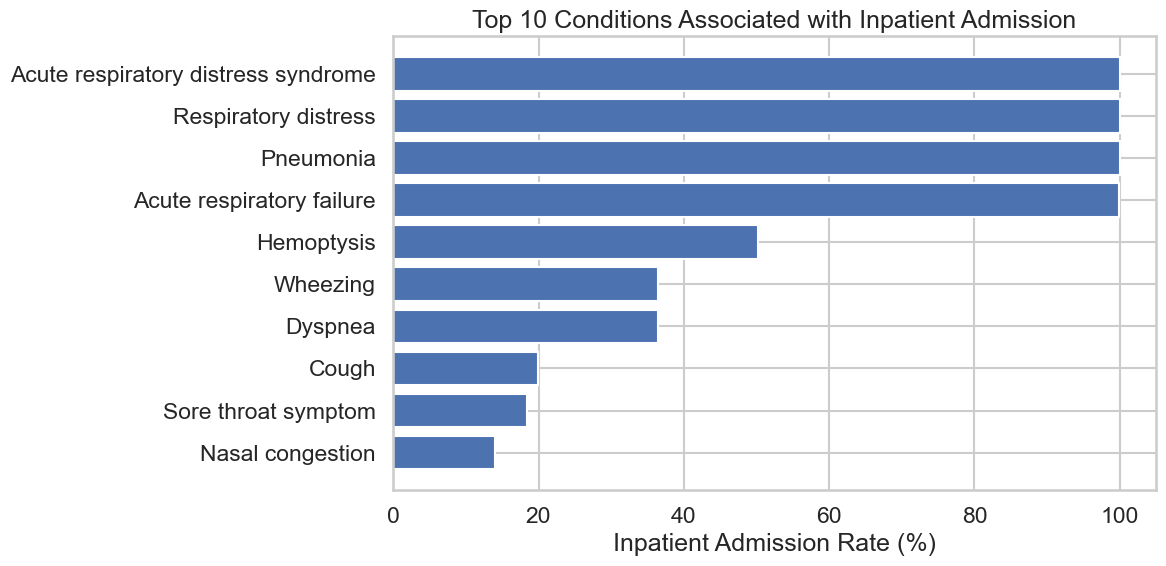

In [52]:
# Merge condition-level data with visit type
import re

cond_rates = (
    df
    .assign(
        condition_item=df['condition'].str.split(r"\s*:\s*")
    )
    .explode('condition_item')
    .dropna(subset=['condition_item'])
    .assign(
        condition_item=lambda x: x['condition_item'].str.strip(),
        is_inpatient=lambda x: x['visit_type'].str.contains('Inpatient', na=False)
    )
    .groupby('condition_item')
    .agg(
        inpatient_rate=('is_inpatient', 'mean'),
        total_visits=('visit_occurrence_id', 'count')
    )
    .reset_index()
)

cond_rates['inpatient_rate'] *= 100

# Filter to conditions with at least 100 visits for statistical reliability
cond_rates_filtered = cond_rates[cond_rates['total_visits'] >= 100]

# Top 10 conditions by inpatient rate
top_inpatient_conditions = cond_rates_filtered.sort_values('inpatient_rate', ascending=False).head(10)

print("Top 10 Conditions with Highest Inpatient Admission Rates:")
print("(minimum 100 visits)\n")
print(top_inpatient_conditions.to_string(index=False))

# Visualization
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_inpatient_conditions)), top_inpatient_conditions['inpatient_rate'])
plt.yticks(range(len(top_inpatient_conditions)), top_inpatient_conditions['condition_item'])
plt.xlabel('Inpatient Admission Rate (%)')
plt.title('Top 10 Conditions Associated with Inpatient Admission')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---
## Part 6: Interpretation and Synthesis

**Goal:** Move from patterns to meaningful insights.

### Exercise 6.1: Synthesis

Based on your exploration, write a brief summary (3-5 bullet points) of the most important findings from this dataset.

**Instructor notes - Sample answers:**

1. **Mortality and oxygen saturation:** There is a strong, statistically significant relationship between low oxygen saturation and mortality. Deceased patients had significantly lower O2 sat levels (mean ~85%) compared to survivors (mean ~95%).

2. **Age-related mortality gradient:** Mortality rates increase sharply with age, with elderly patients (65+) having the highest mortality rates. This suggests age is a critical risk factor.

3. **COVID impact on admissions:** COVID-suspected patients have higher inpatient admission rates compared to non-COVID patients, indicating more severe illness requiring hospitalization.

4. **Comorbidity burden:** Patients with 3+ conditions show worse vital signs on average, suggesting that condition count may be a useful proxy for illness severity.

5. **Temporal patterns:** Visit volume shows clear temporal patterns that likely reflect the COVID-19 pandemic timeline and seasonal respiratory illness patterns.

6. **Data quality concerns:** Several vital sign measurements contain extreme or implausible values that require investigation (e.g., temperatures >42°C, unrealistic blood pressure readings), suggesting data quality issues that need to be addressed before modeling.

### Exercise 6.2: Data Limitations

What are the key limitations of this dataset that affect what questions we can answer?

**Instructor notes - Sample limitations:**

1. **Missing data:** High rates of missing data in vital signs (~60-70% missing for non-COVID visits) limits our ability to compare COVID vs non-COVID patients on clinical measures.

2. **Selection bias:** This is hospital/clinical data, so we only observe patients who sought care. We don't know about patients with mild illness who didn't visit, or population-level incidence.

3. **Synthetic data limitations:** As synthetic data, it may not fully capture real-world complexities, rare conditions, or subtle relationships present in actual patient data.

4. **Temporal censoring:** We only see visits within a specific time window. Long-term outcomes, readmissions after the study period, or prior history before the data collection started are unknown.

5. **Limited treatment information:** We don't have data on treatments received, which makes causal inference about interventions impossible.

6. **Measurement variability:** Vital signs may be measured at different times during the visit, with different equipment, and by different staff, introducing measurement error.

7. **Condition coding:** Conditions are recorded as free text rather than standardized codes (ICD-10, SNOMED), making systematic analysis more difficult and potentially inconsistent.

### Exercise 6.3: Question Classification

For each of the following questions, identify which of the seven question types it represents and whether our data can answer it:

1. "What is the average oxygen saturation for COVID-suspected patients?"
2. "Would providing flu vaccines earlier reduce hospitalizations?"
3. "Can we predict which patients will be admitted as inpatients based on their vital signs?"
4. "Is there a significant difference in mortality between age groups?"

**Instructor answers:**

1. Question type: **Descriptive** | Data support: **YES** - We can calculate this directly from the data

2. Question type: **Causal** | Data support: **NO** - This requires an intervention or experiment. Our observational data cannot establish causation, only correlation between vaccination and outcomes

3. Question type: **Predictive** | Data support: **PARTIALLY** - We have the features (vital signs) and outcome (admission type), but we'd need to build and validate a model. Missing data is a concern.

4. Question type: **Inferential** | Data support: **YES** - We can calculate mortality rates by age group and perform statistical tests to assess if differences are significant

**Teaching points:**
- Descriptive questions are the easiest to answer - they just require summarizing existing data
- Causal questions require experimental or quasi-experimental designs
- Predictive questions require building models and proper validation
- Inferential questions require statistical testing to determine if patterns generalize beyond our sample

### Exercise 6.4: Next Steps

Based on your EDA, what would be your recommended next steps? Choose from:
- Communication and stakeholder alignment
- Modeling preparation
- Data and process redesign
- Goal refinement

Explain your reasoning.

**Instructor notes - Sample answer:**

**Recommended next steps:**

1. **Data and process redesign (HIGH PRIORITY)**
   - Address data quality issues: extreme/implausible vital sign values need investigation
   - Standardize condition coding (currently free text, inconsistent)
   - Improve vital sign capture for non-COVID patients (currently 60-70% missing)
   - Document measurement protocols to reduce variability

2. **Communication and stakeholder alignment (HIGH PRIORITY)**
   - Share findings about mortality risk factors (age, O2 saturation, comorbidities)
   - Discuss data quality concerns with data collection teams
   - Align on which questions are most valuable to answer given data limitations
   - Clarify whether causal questions (e.g., vaccine effectiveness) are goals - if so, different data collection is needed

3. **Goal refinement (MEDIUM PRIORITY)**
   - If the goal is prediction (e.g., admission risk), we can proceed with modeling
   - If the goal is causal inference, we need to redesign data collection or find alternative approaches
   - Clarify the intended use case and success criteria

4. **Modeling preparation (LOWER PRIORITY UNTIL DATA QUALITY IMPROVES)**
   - Only proceed with modeling after addressing data quality issues
   - Develop plan for handling missing vital signs data
   - Consider which modeling approach is appropriate given class imbalance (mortality is relatively rare)
   - Plan validation strategy

**Reasoning:** Data quality issues must be addressed before building models, as "garbage in, garbage out" applies. Stakeholder communication is essential to ensure we're solving the right problem and that stakeholders understand data limitations.

---
## Bonus Exercises

### Bonus 1: Predictive Model Preparation

Prepare features for a model that predicts inpatient admission based on vital signs and demographics.

1. Select relevant features
2. Handle missing values
3. Create the target variable
4. Check class balance

In [53]:
# Predictive modeling preparation

# 1. Select features
feature_cols = [
    'age_at_visit_years',
    'oxygen_saturation_percent',
    'respiratory_rate_per_minute',
    'heart_rate_bpm',
    'body_temperature_c',
    'systolic',
    'diastolic',
    'condition_count',
    'gender_source_value',
    'age_group'
]

# 3. Create target variable
modeling_df = covid_df.copy()
modeling_df['is_inpatient'] = modeling_df['visit_type'].str.contains('Inpatient', na=False).astype(int)

# 4. Check class balance
print("Target Variable Distribution:")
print(modeling_df['is_inpatient'].value_counts())
print(f"\nInpatient rate: {modeling_df['is_inpatient'].mean()*100:.1f}%")

# Check missing values in features
print("\nMissing Values in Features:")
missing_pct = modeling_df[feature_cols].isnull().sum() / len(modeling_df) * 100
print(missing_pct[missing_pct > 0])

# 2. Handle missing values - simple imputation strategy
from sklearn.impute import SimpleImputer

# For numeric columns, impute with median
numeric_features = ['age_at_visit_years', 'oxygen_saturation_percent',
                   'respiratory_rate_per_minute', 'heart_rate_bpm',
                   'body_temperature_c', 'systolic', 'diastolic', 'condition_count']

imputer = SimpleImputer(strategy='median')
modeling_df[numeric_features] = imputer.fit_transform(modeling_df[numeric_features])

print("\nData prepared for modeling!")
print(f"Total samples: {len(modeling_df)}")
print(f"Features: {len(feature_cols)}")
print(f"Class balance: {modeling_df['is_inpatient'].value_counts(normalize=True)*100}")

Target Variable Distribution:
is_inpatient
0    56830
1    16464
Name: count, dtype: int64

Inpatient rate: 22.5%

Missing Values in Features:
oxygen_saturation_percent      0.019101
respiratory_rate_per_minute    0.004093
heart_rate_bpm                 0.004093
body_temperature_c             0.015008
systolic                       0.004093
diastolic                      0.004093
age_group                      0.987803
dtype: float64

Data prepared for modeling!
Total samples: 73294
Features: 10
Class balance: is_inpatient
0    77.537043
1    22.462957
Name: proportion, dtype: float64


### Bonus 2: Condition Co-occurrence

Create a co-occurrence matrix showing which conditions tend to appear together.

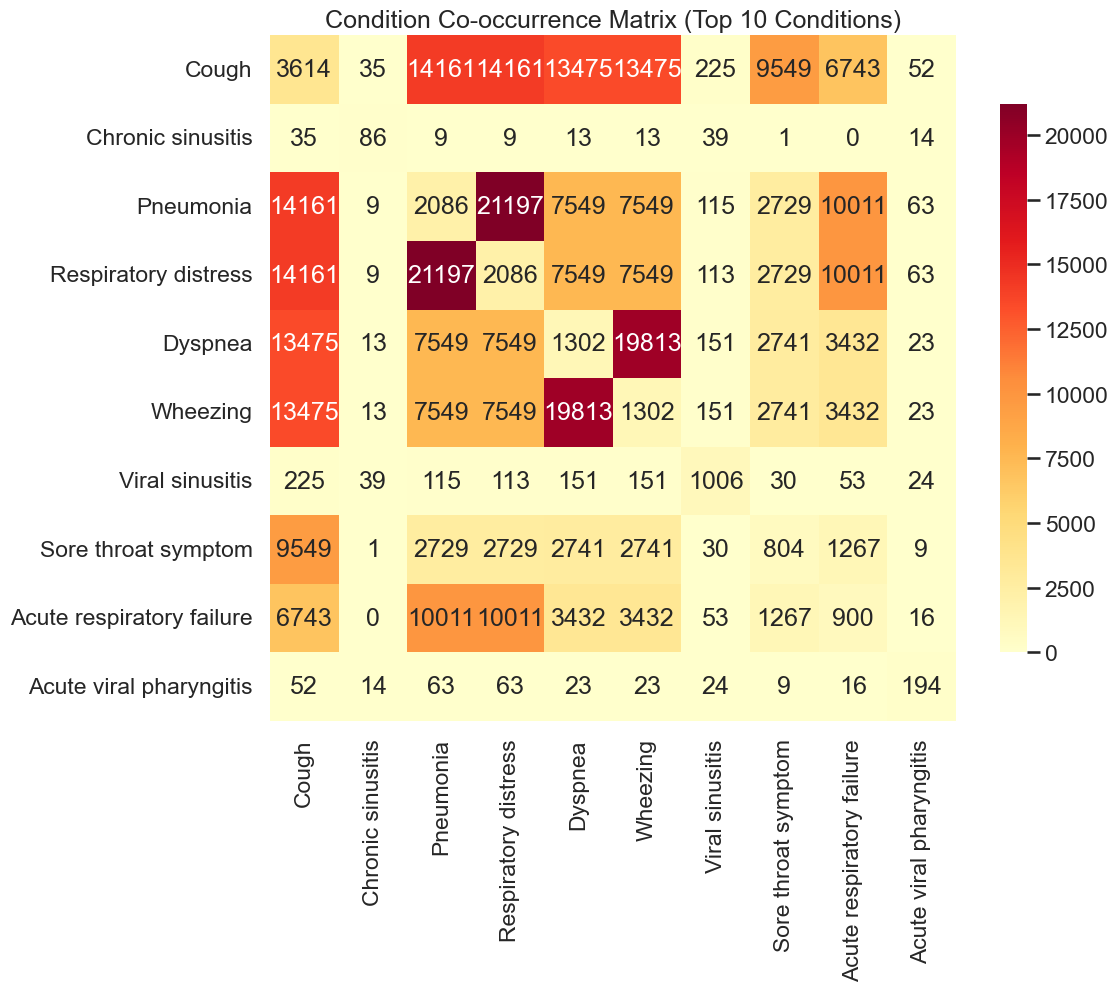


Top condition pairs:
Pneumonia             Respiratory distress         21197.0
Dyspnea               Wheezing                     19813.0
Cough                 Respiratory distress         14161.0
                      Pneumonia                    14161.0
                      Dyspnea                      13475.0
                      Wheezing                     13475.0
Respiratory distress  Acute respiratory failure    10011.0
Pneumonia             Acute respiratory failure    10011.0
Cough                 Sore throat symptom           9549.0
Pneumonia             Wheezing                      7549.0
dtype: float64


In [54]:
# Create condition co-occurrence matrix
from itertools import combinations
from collections import defaultdict

# Get top 10 most common conditions
top_conditions = all_conditions.value_counts().head(10).index.tolist()

# Initialize co-occurrence matrix
cooc_matrix = pd.DataFrame(0, index=top_conditions, columns=top_conditions)

# Count co-occurrences
for conditions in df['condition_list'].dropna():
    # Clean and filter to top conditions
    conditions_clean = [c.strip() for c in conditions if c.strip() in top_conditions]
    # Count pairs
    for cond1, cond2 in combinations(conditions_clean, 2):
        cooc_matrix.loc[cond1, cond2] += 1
        cooc_matrix.loc[cond2, cond1] += 1

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(cooc_matrix, annot=True, fmt='d', cmap='YlOrRd', square=True, 
            cbar_kws={"shrink": 0.8})
plt.title('Condition Co-occurrence Matrix (Top 10 Conditions)')
plt.tight_layout()
plt.show()

print("\nTop condition pairs:")
# Get upper triangle
mask = np.triu(np.ones_like(cooc_matrix, dtype=bool), k=1)
pairs = cooc_matrix.where(mask).stack().sort_values(ascending=False)
print(pairs.head(10))

### Bonus 3: Patient Journey Visualization

For patients with multiple visits, visualize their journey over time (conditions and visit types).

Patient Journey for Patient 16
Total visits: 3



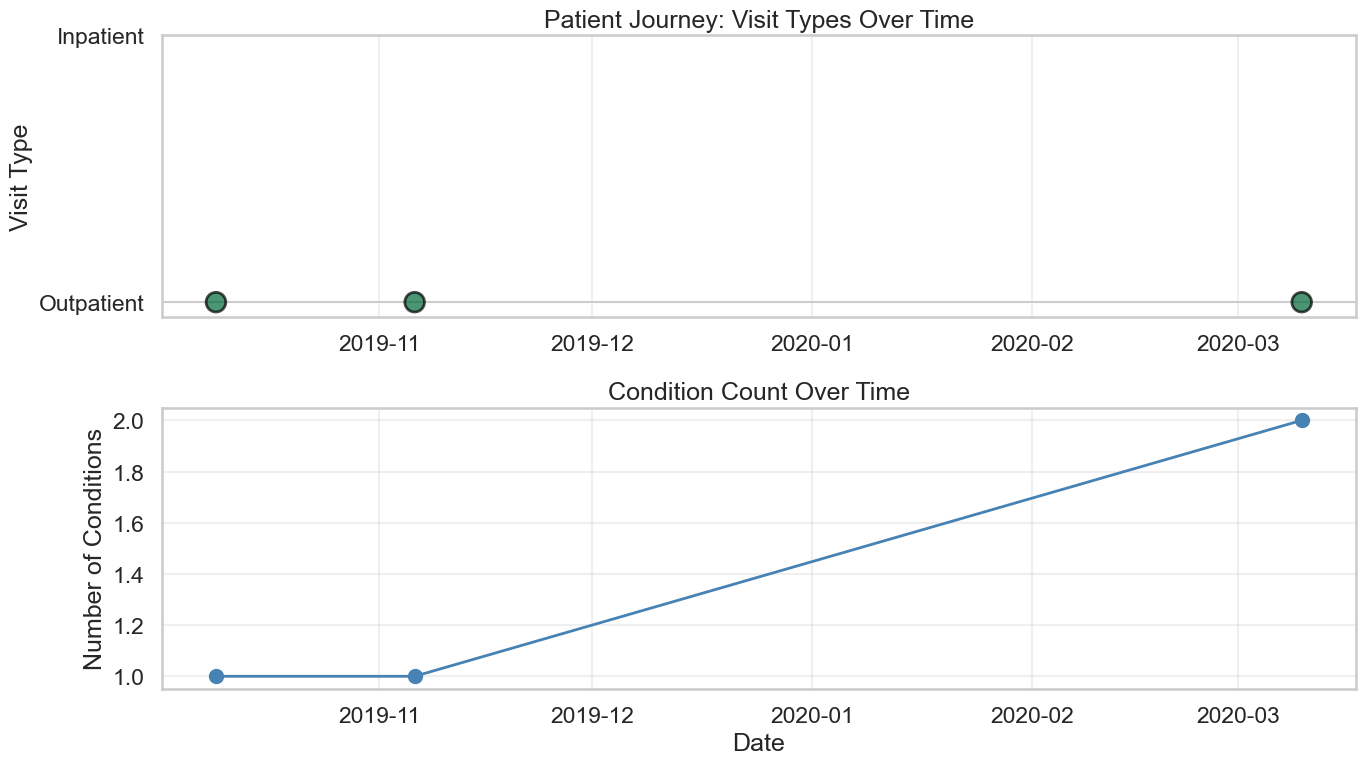


Detailed Visit History:

Visit 335:
  Date: 2019-10-09
  Type: Outpatient Visit
  Conditions: Acute bacterial sinusitis
  Length of stay: 0 days

Visit 336:
  Date: 2019-11-06
  Type: Outpatient Visit
  Conditions: Chronic sinusitis
  Length of stay: 0 days

Visit 338:
  Date: 2020-03-10
  Type: Outpatient Visit
  Conditions: Sore throat symptom:Cough
  Length of stay: 0 days
  O2 Saturation: 85.6%


In [55]:
# Select a patient with multiple visits
multi_visit_patients = df.groupby('person_id').size()
patient_id = multi_visit_patients[multi_visit_patients >= 3].index[0]  # Get first patient with 3+ visits

patient_data = df[df['person_id'] == patient_id].sort_values('visit_start_date')

print(f"Patient Journey for Patient {patient_id}")
print(f"Total visits: {len(patient_data)}\n")

# Create timeline visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Visit types over time
visit_types = patient_data['visit_type'].map({'Inpatient Visit': 1, 'Outpatient Visit': 0})
ax1.scatter(patient_data['visit_start_date'], visit_types, s=200, c=visit_types, 
           cmap='RdYlGn_r', alpha=0.7, edgecolors='black', linewidth=2)
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['Outpatient', 'Inpatient'])
ax1.set_ylabel('Visit Type')
ax1.set_title(f'Patient Journey: Visit Types Over Time')
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Number of conditions over time
condition_counts = patient_data['condition_count']
ax2.plot(patient_data['visit_start_date'], condition_counts, marker='o', 
        markersize=10, linewidth=2, color='steelblue')
ax2.set_ylabel('Number of Conditions')
ax2.set_xlabel('Date')
ax2.set_title('Condition Count Over Time')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed visit information
print("\nDetailed Visit History:")
for idx, row in patient_data.iterrows():
    print(f"\nVisit {row['visit_occurrence_id']}:")
    print(f"  Date: {row['visit_start_date'].date()}")
    print(f"  Type: {row['visit_type']}")
    print(f"  Conditions: {row['condition']}")
    print(f"  Length of stay: {row['length_of_stay']} days")
    if pd.notna(row['oxygen_saturation_percent']):
        print(f"  O2 Saturation: {row['oxygen_saturation_percent']:.1f}%")

---
## Summary: Key EDA Concepts

### The EDA Lifecycle
1. Clarify the analytical goal
2. Understand data provenance, structure, and integrity
3. Explore (distributional, relational, structural, comparative)
4. Interpret findings and refine hypotheses
5. Translate results into next steps

### The Seven Question Types
1. Descriptive — What happened?
2. Exploratory — What patterns exist?
3. Inferential — Does this generalize?
4. Predictive — What will happen?
5. Prescriptive — What should we do?
6. Causal — What if we intervene?
7. Mechanistic — What process produces this?

### The Four Exploration Dimensions
1. **Distributional** — Individual variable shape, outliers, missingness
2. **Relational** — Correlations, interactions between variables
3. **Structural** — Temporal, hierarchical, sequential patterns
4. **Comparative** — Differences across groups and time periods

### The Seven Core Principles
1. Let the data surprise you
2. Multiple encodings, multiple perspectives
3. Segment early, segment often
4. Explicitly check assumptions
5. Expect heterogeneity and drift
6. Distinguish signal from artifact
7. Document hypotheses and alternative explanations